# Libraries Importing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score

**Removing Unimportant Warnings**

In [2]:
import warnings
from numpy import RankWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RankWarning)

# Data Description

## Data Reading

In [3]:
df = pd.read_csv('dataset.csv')

## Data samples

In [4]:
pd.set_option('display.max_columns', None)
df.head()

,User ID,User Name,Driver Name,Car Condition,Weather,Traffic Condition,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,distance,bearing
0,KHVrEVlD,Kimberly Adams,Amy Butler,Very Good,windy,Congested Traffic,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-1.288826,0.710721,-1.288779,0.710563,1,17,15,6,0,2009,20.265840,55.176046,14.342611,34.543548,27.572573,1.030764,-2.918897
1,lPxIuEri,Justin Tapia,Hannah Zimmerman,Excellent,cloudy,Flow Traffic,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-1.291824,0.710546,-1.291182,0.711780,1,16,5,1,1,2010,44.667679,31.832358,23.130775,15.125872,8.755732,8.450134,-0.375217
2,gsVN8JLS,Elizabeth Lopez,Amanda Jackson,Bad,stormy,Congested Traffic,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-1.291242,0.711418,-1.291391,0.711231,2,0,18,8,3,2011,43.597686,33.712082,19.865289,17.722624,9.847344,1.389525,2.599961
3,9I7kWFgd,Steven Wilson,Amy Horn,Very Good,stormy,Flow Traffic,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-1.291319,0.710927,-1.291396,0.711363,1,4,21,4,5,2012,42.642965,32.556289,21.063132,15.738963,7.703421,2.799270,0.133905
4,8QN5ZaGN,Alexander Andrews,Cassandra Larson,Bad,stormy,Congested Traffic,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-1.290987,0.711536,-1.290787,0.711811,1,7,9,3,1,2010,43.329953,39.406828,15.219339,23.732406,15.600745,1.999157,-0.502703


## Project Description

This project leverages machine learning techniques to enhance operational efficiency for a transportation company. The dataset at hand encompasses comprehensive trip information, which serves as the foundational input for predictive modeling. The primary objective of this project is to accurately predict the fare of trips, thereby enabling informed decision-making and optimized pricing strategies.

## Features Description

- **User ID & User Name**: The unique identifier and name of the passenger.
- **Driver Name**: The name of the driver.
- **Car Condition**: The condition of the car during the trip.
- **Weather & Traffic Condition**: The state of weather and traffic conditions during the trip.
- **Key**: A unique identifier for the trip, containing information about the pickup datetime.
- **Fare Amount**: The fare charged for the trip.
- **Pickup Datetime**: The pickup datetime, formatted differently than in the 'key' feature.
- **Pickup Longitude & Pickup Latitude / Dropoff Longitude & Dropoff Latitude**: The pickup and dropoff locations, using longitude and latitude coordinates.
- **Passenger Count**: The number of passengers.
- **Hour, Day, Month, Year**: The individual components of the pickup datetime.
- **Weekday**: Represents the day of the week, starting from Monday as 0.
- **JFK Dist, EWR Dist, LGA Dist**: The distances from the pickup location to various airports (John F. Kennedy in New York, Newark Liberty in New Jersey, and LaGuardia in New York).
- **SOL Dist**: The distance from the pickup location to the Statue of Liberty in New York.
- **NYC Dist**: The distance from the pickup location to New York City.
- **Distance & Bearing**: The distance and the direction by angles in which a trip is heading.

## Data Info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   User ID            500000 non-null  object 
 1   User Name          500000 non-null  object 
 2   Driver Name        500000 non-null  object 
 3   Car Condition      500000 non-null  object 
 4   Weather            500000 non-null  object 
 5   Traffic Condition  500000 non-null  object 
 6   key                500000 non-null  object 
 7   fare_amount        500000 non-null  float64
 8   pickup_datetime    500000 non-null  object 
 9   pickup_longitude   500000 non-null  float64
 10  pickup_latitude    500000 non-null  float64
 11  dropoff_longitude  499995 non-null  float64
 12  dropoff_latitude   499995 non-null  float64
 13  passenger_count    500000 non-null  int64  
 14  hour               500000 non-null  int64  
 15  day                500000 non-null  int64  
 16  mo

## Duplicated Features

### Datetime Extraction Function

In [6]:
def datetime_extraction(df, column):
    datetime = df[column].str.split(' ', expand=True).rename(columns={0: 'date', 1: 'clock'})
    date_components = datetime['date'].str.split('-', expand=True).astype(int)
    date_components.columns = ['year', 'month', 'day']
    time_components = datetime['clock'].str.split(':', expand=True).astype(float)
    time_components.columns = ['hour', 'minute', 'second']
    datetime = pd.concat([date_components, time_components], axis=1)
    return datetime


In [7]:
key = datetime_extraction(df, 'key')
pickup_datetime = datetime_extraction(df, 'pickup_datetime')
pickup_datetime.head()

,year,month,day,hour,minute,second
0,2009,6,15,17.0,26.0,21.0
1,2010,1,5,16.0,52.0,16.0
2,2011,8,18,0.0,35.0,0.0
3,2012,4,21,4.0,30.0,42.0
4,2010,3,9,7.0,51.0,0.0


### The Difference Between key and pickup_datetime

In [8]:
for column in key.columns:
    difference = key[key[column] - pickup_datetime[column] > 0.0001][column]
    print(column, 'difference:', len(difference))


year difference: 0
month difference: 0
day difference: 0
hour difference: 0
minute difference: 0
second difference: 0


### The Difference Between key and (Hour & day & month & year) Features

In [9]:
for column in key.columns:
    if column in ['minute', 'second']:
        continue
    difference = key[key[column] - df[column] > 0.0001][column]
    print(column, 'difference:', len(difference))

year difference: 0
month difference: 0
day difference: 0
hour difference: 0


The features key and pickup_datetime give same info as (Hour & day & month & year) Features

**Costing Features can be dropped:**
- User ID
- User Name
- Driver Name

**Features giving the same information:**
- Key
- Pickup Datetime
- Hour, Day, Month, Year

**Features need encoding:**
- Car Condition
- Weather
- Traffic Condition

# Data Preprocessing

## Features Renaming

Converting column names to lowercase and replacing spaces with underscores for easier management

In [10]:
for column in df.columns:
    new_column = column.lower().replace(' ', '_')
    df.rename(columns={column: new_column}, inplace=True)

print(df.columns)

Index(['user_id', 'user_name', 'driver_name', 'car_condition', 'weather',
       'traffic_condition', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'hour', 'day', 'month',
       'weekday', 'year', 'jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist',
       'nyc_dist', 'distance', 'bearing'],
      dtype='object')


## Nulls

### Nulls Count

In [11]:
nulls = df.shape[0] - df.notna().sum()
for x in nulls.index:
    if nulls[x] == 0:
        continue

    print(x, "Nulls:", nulls[x])
    print('Nulls Percentage:', format(nulls[x] / df.shape[0] * 100, '0.3f') + '%')
    print('-'*25)

dropoff_longitude Nulls: 5
Nulls Percentage: 0.001%
-------------------------
dropoff_latitude Nulls: 5
Nulls Percentage: 0.001%
-------------------------
jfk_dist Nulls: 5
Nulls Percentage: 0.001%
-------------------------
ewr_dist Nulls: 5
Nulls Percentage: 0.001%
-------------------------
lga_dist Nulls: 5
Nulls Percentage: 0.001%
-------------------------
sol_dist Nulls: 5
Nulls Percentage: 0.001%
-------------------------
nyc_dist Nulls: 5
Nulls Percentage: 0.001%
-------------------------
distance Nulls: 5
Nulls Percentage: 0.001%
-------------------------
bearing Nulls: 5
Nulls Percentage: 0.001%
-------------------------


Few Numer of nulls which can be dropped

### Nulls Dropping

In [12]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

## Duplicates

In [13]:
print("Number of duplicates = ", df.duplicated().sum())

Number of duplicates =  0


## Outliers

### Count

In [14]:
for column in df.select_dtypes('float64', 'int64'):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers_count = df[(df[column] < lower_bound) | (df[column] > upper_bound)].shape[0]
    if outliers_count == 0:
        continue
    print(column, "Outliers:", outliers_count)
    print("Percentage:", format(outliers_count / df.shape[0] * 100, '0.2f') + '%')

fare_amount Outliers: 43329
Percentage: 8.67%
pickup_longitude Outliers: 33965
Percentage: 6.79%
pickup_latitude Outliers: 23701
Percentage: 4.74%
dropoff_longitude Outliers: 35805
Percentage: 7.16%
dropoff_latitude Outliers: 30748
Percentage: 6.15%
jfk_dist Outliers: 59285
Percentage: 11.86%
ewr_dist Outliers: 28380
Percentage: 5.68%
lga_dist Outliers: 22539
Percentage: 4.51%
sol_dist Outliers: 18610
Percentage: 3.72%
nyc_dist Outliers: 21940
Percentage: 4.39%
distance Outliers: 41925
Percentage: 8.39%


**Outliers represent big percentage of Data, they should be replaced with Min/Max**

### Outliers Replacing with Min/Max

In [15]:
for column in df.select_dtypes('float64', 'int64'):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df[column] = df[column].apply(lambda x: min(upper_bound, max(lower_bound, x)))

## Weekday into categorical data

In [16]:
days = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
day_name = [days[x] for x in df['weekday']]
df.insert(df.columns.get_loc('weekday') + 1, 'day_name', day_name)

## Costing Features Dropping 

In [17]:
def drop_costing_features(df):
    df.drop(columns=['user_id', 'user_name', 'driver_name', 'key', 'pickup_datetime'], axis=1, inplace=True)

## Encoding

### Unique Values from Categorical columns

In [18]:
for column in ['car_condition', 'traffic_condition', 'weather']:
    print(column, "Unique Values:", df[column].unique())

car_condition Unique Values: ['Very Good' 'Excellent' 'Bad' 'Good']
traffic_condition Unique Values: ['Congested Traffic' 'Flow Traffic' 'Dense Traffic']
weather Unique Values: ['windy' 'cloudy' 'stormy' 'sunny' 'rainy']


- **Car Condition** & **Traffic Condition**: Has sorted Values, Ordinal encoding will be used.
- **Weather**: Has unsorted Values, One Hot encoding can be used.

### Encoding Function

In [19]:
encoder = OneHotEncoder(sparse_output=False)
def encoding(df):
    car_c_sorted = ['Bad', 'Good', 'Very Good', 'Excellent']
    car_condition_encoded = [car_c_sorted.index(x) for x in df['car_condition']]
    df.insert(df.columns.get_loc('car_condition') + 1, 'car_condition_encoded', car_condition_encoded)

    traffic_c_sorted = ['Congested Traffic', 'Dense Traffic', 'Flow Traffic']
    traffic_condition_encoded = [traffic_c_sorted.index(x) for x in df['traffic_condition']]
    df.insert(df.columns.get_loc('traffic_condition') + 1, 'traffic_condition_encoded', traffic_condition_encoded)

    weather_encoded = encoder.fit_transform(df[['weather']])
    weather_encoded = pd.DataFrame(weather_encoded, columns=encoder.get_feature_names_out())
    for column in weather_encoded.columns:
        df.insert(df.columns.get_loc('weather') + 1, column.removeprefix('weather_'), weather_encoded[column])

## Preprocessing Function

Combining all preprocessing steps into a single function for easier management

In [20]:
def preprocessing(df):
    drop_costing_features(df)
    encoding(df)

preprocessing(df)

## Divide the columns into categorical and numerical

In [21]:
categorical_columns = df.select_dtypes('object').columns
numerical_columns = df.select_dtypes(['int64', 'float64']).columns
print('categorical_columns:', categorical_columns)
print('numerical_columns:', numerical_columns)

categorical_columns: Index(['car_condition', 'weather', 'traffic_condition', 'day_name'], dtype='object')
numerical_columns: Index(['car_condition_encoded', 'windy', 'sunny', 'stormy', 'rainy', 'cloudy',
       'traffic_condition_encoded', 'fare_amount', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'hour', 'day', 'month', 'weekday', 'year',
       'jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist', 'nyc_dist', 'distance',
       'bearing'],
      dtype='object')


# Data Statistics and Visualization

## Statistics Overview

In [22]:
df.describe()

,car_condition_encoded,windy,sunny,stormy,rainy,cloudy,traffic_condition_encoded,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,distance,bearing
count,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000
mean,1.499635,0.199154,0.200868,0.199912,0.199944,0.200122,0.999444,10.083832,-1.291164,0.711226,-1.291127,0.711227,1.683445,13.510843,15.684239,6.268617,3.042020,2011.739129,42.459166,35.695787,19.711890,19.081904,11.294186,2.860042,0.297145
std,1.117535,0.399364,0.400650,0.399934,0.399958,0.400092,0.816600,5.451940,0.000358,0.000446,0.000400,0.000499,1.307391,6.511596,8.681092,3.437798,1.949243,1.860897,2.354308,4.858864,4.105892,5.736194,5.607058,2.234903,1.804548
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.750000,-1.292058,0.710116,-1.292121,0.710051,0.000000,0.000000,1.000000,1.000000,0.000000,2009.000000,37.675311,22.977528,9.429682,3.590754,0.080500,0.000000,-3.141593
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,-1.291405,0.710958,-1.291393,0.710943,1.000000,9.000000,8.000000,3.000000,1.000000,2010.000000,41.341514,32.173712,17.100762,14.886989,7.147384,1.214550,-0.854721
50%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.500000,-1.291226,0.711268,-1.291197,0.711277,1.000000,14.000000,16.000000,6.000000,3.000000,2012.000000,42.523163,34.787507,19.591554,18.347580,10.458151,2.116970,-0.050442
75%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,12.500000,-1.290970,0.711520,-1.290908,0.711538,2.000000,19.000000,23.000000,9.000000,5.000000,2013.000000,43.785649,38.304502,22.214815,22.417812,14.448699,3.890070,2.206769
max,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,22.250000,-1.290317,0.712362,-1.290180,0.712430,6.000000,23.000000,31.000000,12.000000,6.000000,2015.000000,47.451852,47.500686,29.885895,33.714047,25.400672,7.903349,3.141593


- **Fare Amount**: Contains negative values that may be incorrectly added.
- **Passenger Count**: Most trips have 1 or 2 passengers. Some trips have 0 passengers, which is not natural, while others have up to 6 passengers.
- **Year**: The data ranges from 2009 to 2015.
- **Distance**: Some trips have a distance of 0, which is not natural.
- **Bearing**: Calculated in Radian.

## Pickup and Dropoff Locations

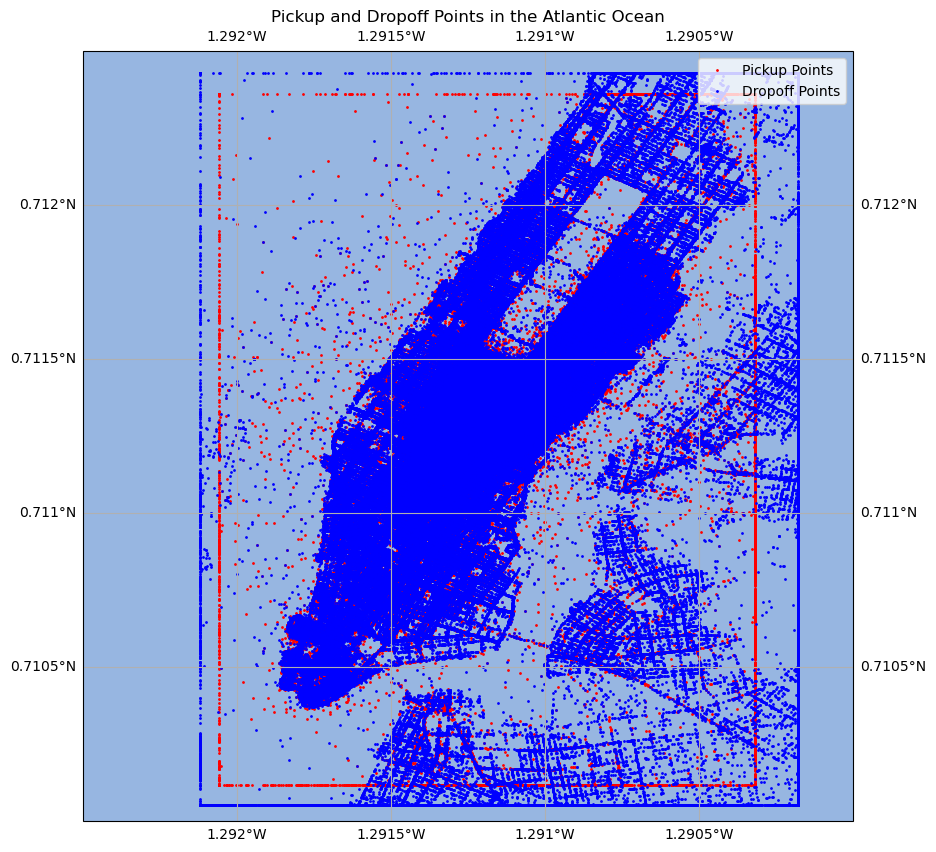

In [23]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Sample longitude and latitude points
pickup_longitudes = df['pickup_longitude']
pickup_latitudes = df['pickup_latitude']
dropoff_longitudes = df['dropoff_longitude']
dropoff_latitudes = df['dropoff_latitude']

# Create a figure with a larger size
fig = plt.figure(figsize=(15, 10))

# Create a map projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the map extent to focus on the tight cluster of points
ax.set_extent([-1.2925, -1.2900, 0.7100, 0.7125], crs=ccrs.PlateCarree())  # Zoomed in

# Add map features
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.OCEAN)

# Plot the pickup points
ax.plot(pickup_longitudes, pickup_latitudes, 'ro', markersize=1, transform=ccrs.PlateCarree(), label='Pickup Points')

# Plot the dropoff points
ax.plot(dropoff_longitudes, dropoff_latitudes, 'bo', markersize=1, transform=ccrs.PlateCarree(), label='Dropoff Points')

# Add gridlines and labels
ax.gridlines(draw_labels=True)

# Add a legend and title
plt.legend(loc='upper right')
plt.title("Pickup and Dropoff Points in the Atlantic Ocean")

# Show the map
plt.show()

**Summary:**  
All the points are situated in the ocean. As these are incorrect data, they should be disregarded.

### Pickup and dropoff locations dropping

In [24]:
df.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1, inplace=True)
numerical_columns = df.select_dtypes(['int64', 'float64']).columns

## Distribution Visualization Function

In [25]:
def distribution_vis(df, title):
    rows = math.ceil(len(df.columns) / 3.0)
    fig, axes = plt.subplots(rows, 3, figsize = (15, 4 * rows))

    x = 0
    axes = axes.flatten()
    for column in df.columns:
        if column in ['weekday', 'sunny', 'windy', 'stormy', 'cloudy', 'rainy'] or 'encoded' in column:
            continue
        if column in categorical_columns:
            sns.barplot(ax=axes[x], x=df[column].value_counts().index, y= df[column].value_counts(normalize= True).values * 100)
        else:
            sns.histplot(ax=axes[x], x=df[column], stat='percent')
        axes[x].set_title(title + column)
        axes[x].set_xlabel(column)
        for label in axes[x].get_xticklabels():
            label.set_rotation(45)
        axes[x].set_ylabel('Percentage (%)')
        x += 1

    for i in range(x, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

## Features Distribution

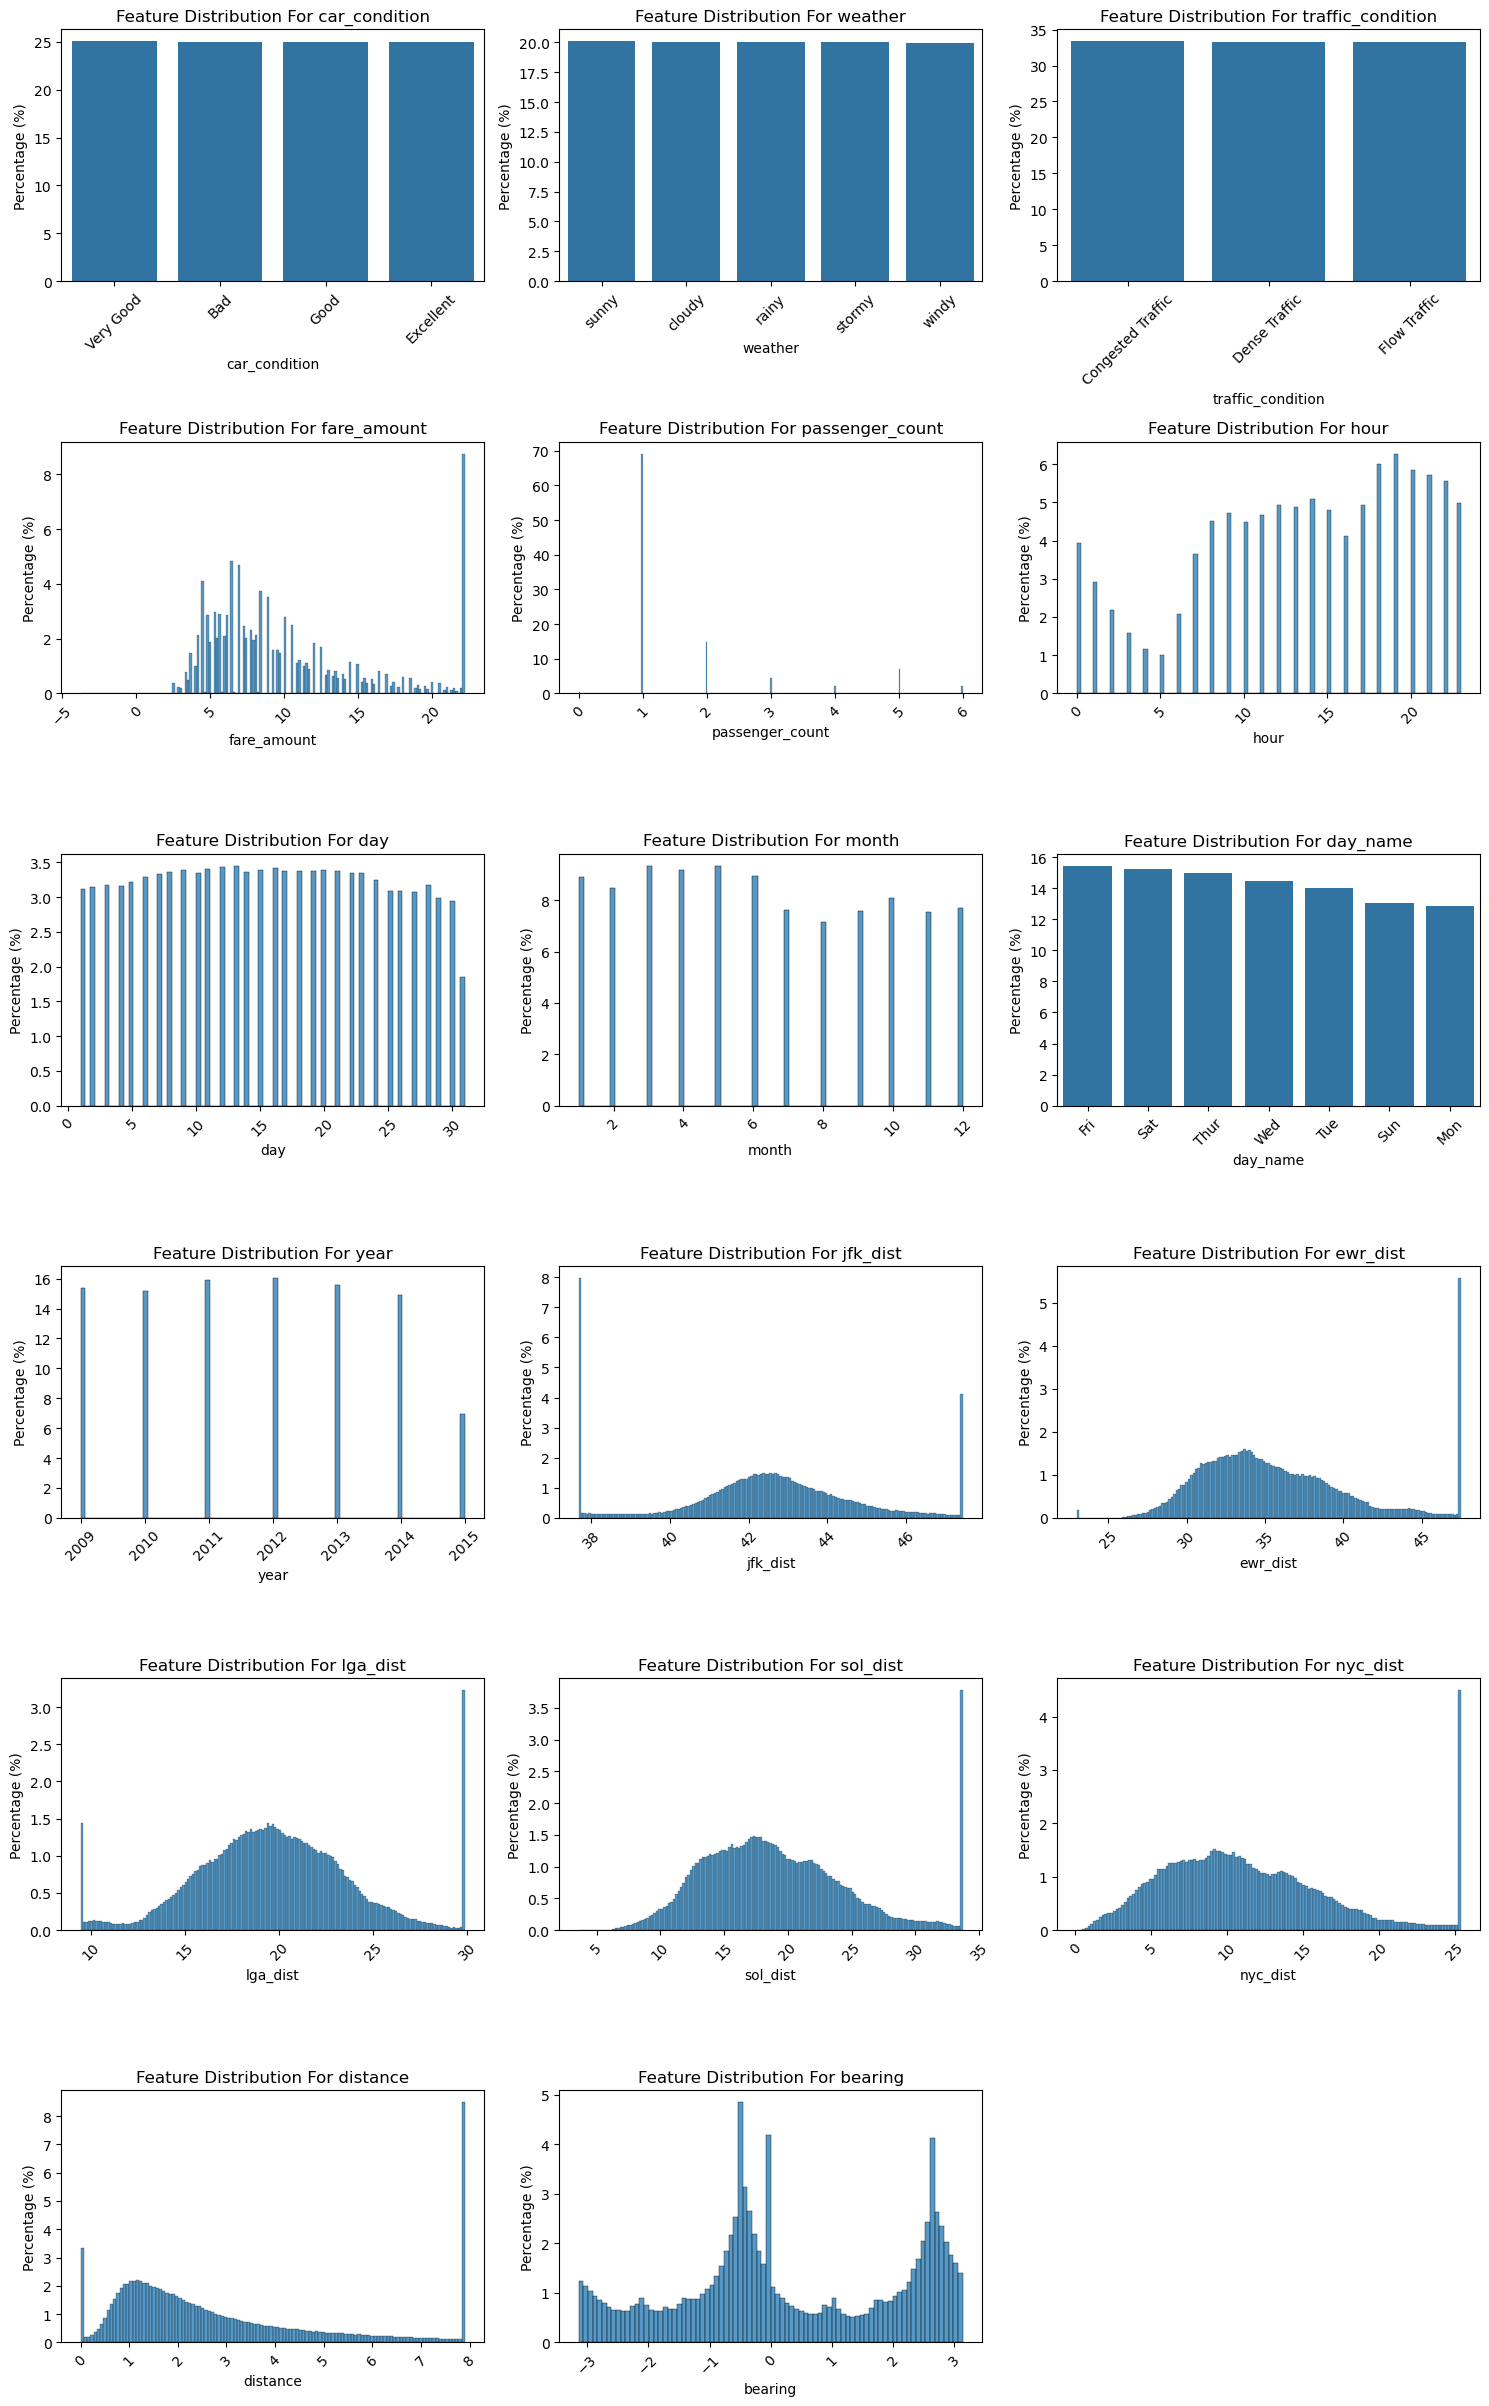

In [26]:
distribution_vis(df, "Feature Distribution For ")

**Features Distribution Summary**:
- **Fare & Passenger Count**: Right skewed, favoring lower values.
- **Hour**:
  - Most trips occur between 6 PM and 7 PM.
  - A noticeable drop from 7 PM to 5 AM.
  - Steady number of trips from 5 AM to 7 PM.
- **Month**: Higher trip frequency in the first six months of the year.
- **Day**: Most trips occur on weekends (Friday and Saturday), with the fewest on Monday.
- **Year**: Trips increased from 2010 to 2012, then declined.
- **jfk_dist, ewr_dist, lga_dist, sol_dist, nyc_dist**: Normally distributed around the mean.
- **Trip Distance**: Right skewed, favoring lower values.
- **Bearing**: Primarily around zero and three.

## Negative Fare Amount

### Count

In [27]:
print("The count:", df[df['fare_amount'] < 0].shape[0])

print("The Percentage:", format(df[df['fare_amount'] < 0].shape[0] / df.shape[0] * 100, '0.5f') + '%')

The count: 21
The Percentage: 0.00420%


### Negative Fare vs Features

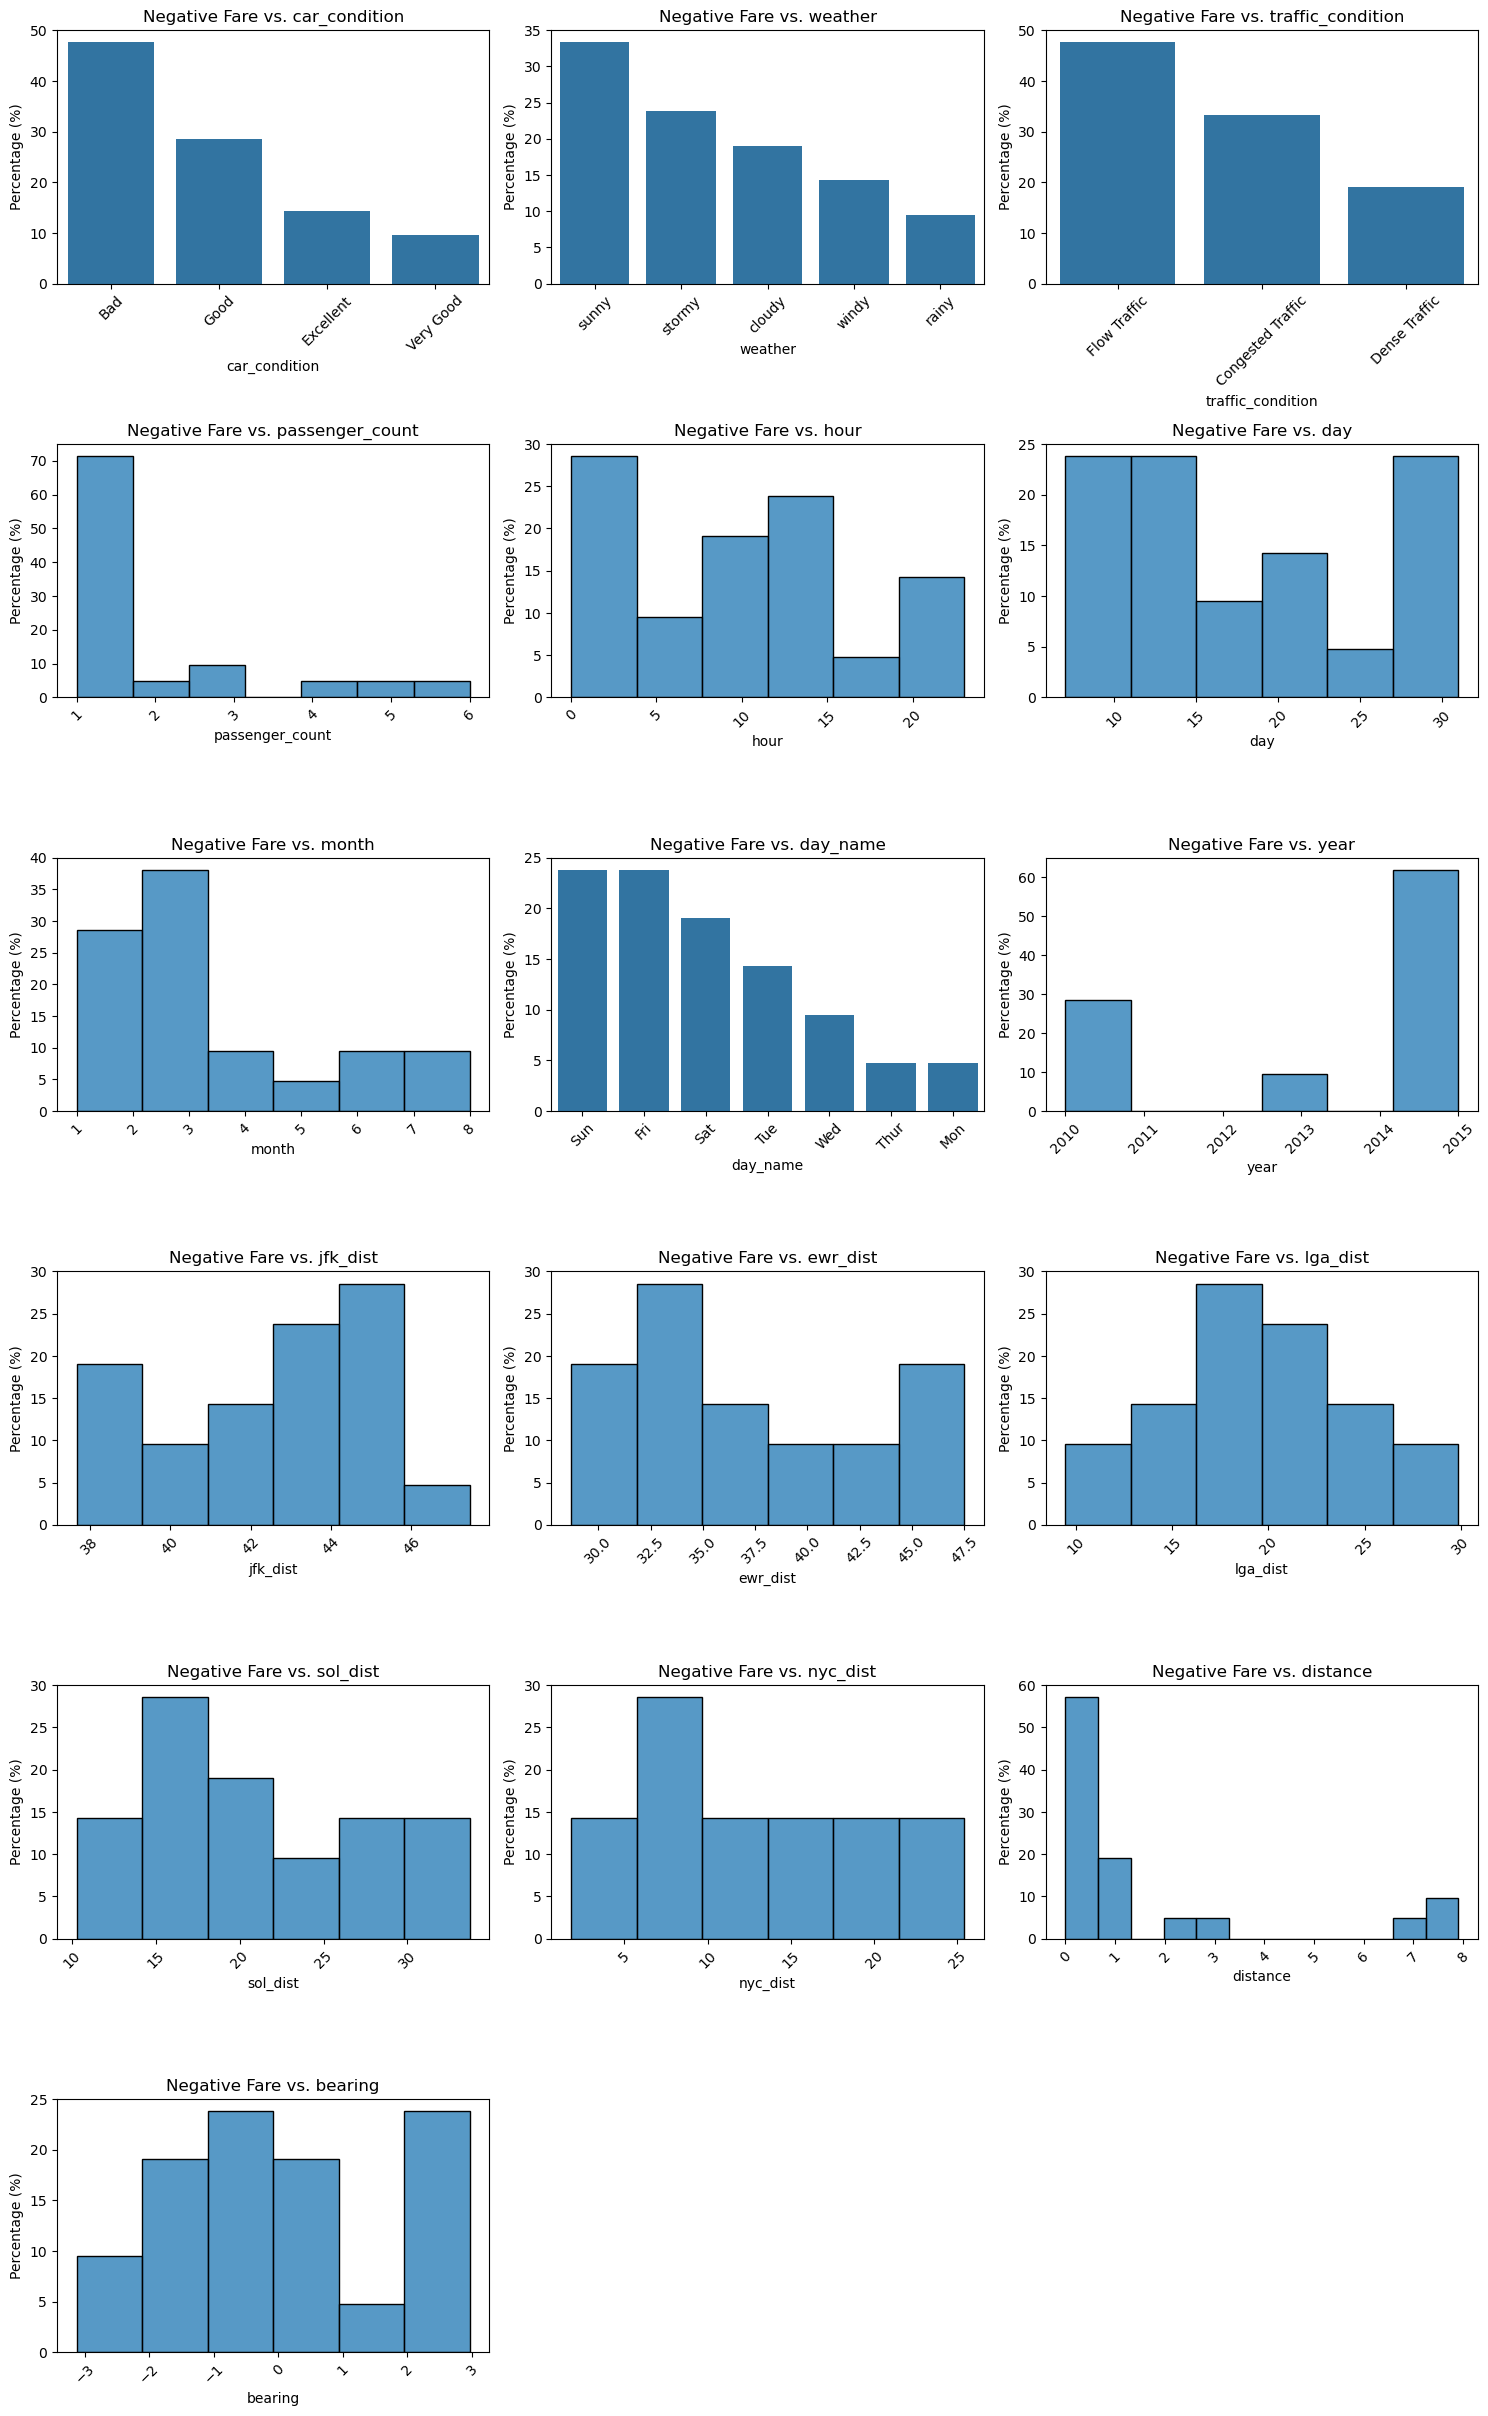

In [28]:
columns = [x for x in df.columns if 'fare' not in x]
distribution_vis(df[df['fare_amount'] < 0][columns], "Negative Fare vs. ")

**Summary of Negative Fare vs. Features**:

- **Car Condition**: Most cars are in poor condition.
- **Weather**: Primarily sunny days.
- **Traffic**: Generally smooth-flowing.
- **Hour**: Most trips occur at 12 AM.
- **Day**: Most trips take place on Sunday and Friday, with fewer trips on Sunday.
- **Year**: Most trips happened in 2015, despite having the lowest overall trip rate.

**Negative fares might be attributed to discounts due to the poor condition of the cars.**

## Zero Fare Amount

### Count

In [29]:
print("The count:", df[df['fare_amount'] == 0].shape[0])
print("The Percentage:", format(df[df['fare_amount'] == 0].shape[0] / df.shape[0] * 100, '0.5f') + '%')

The count: 14
The Percentage: 0.00280%


### Zero Fare vs Features

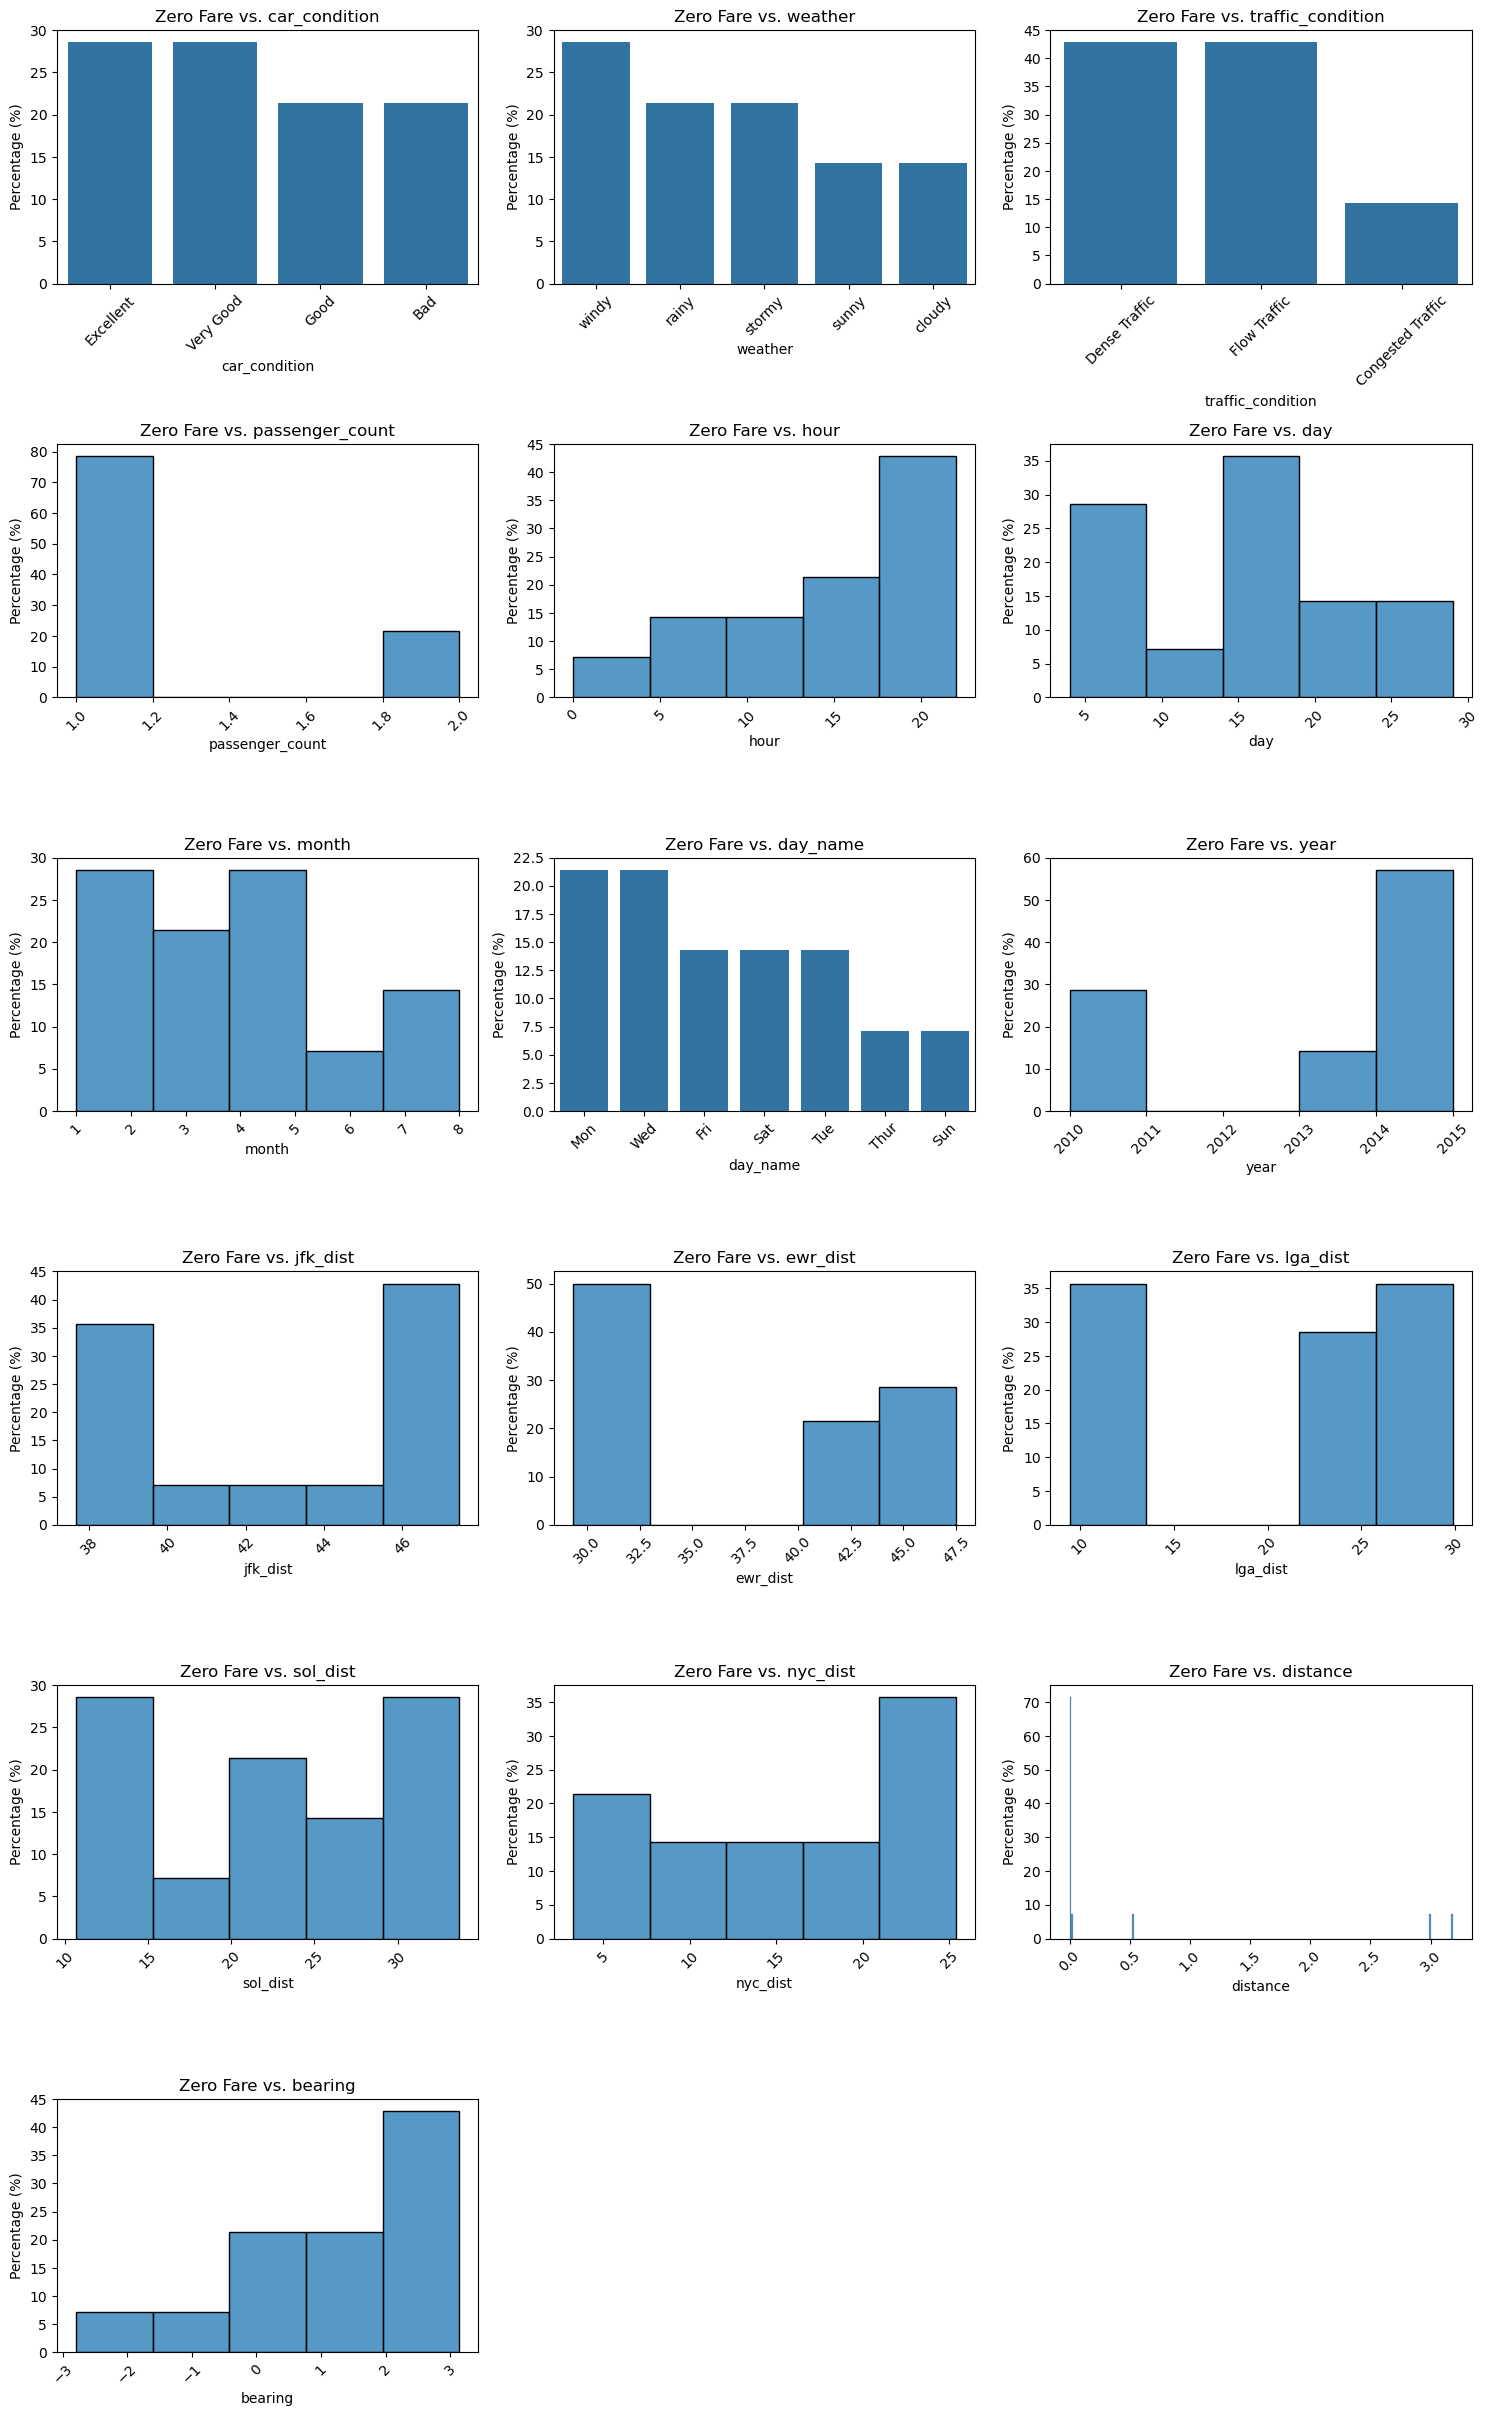

In [30]:
columns = [x for x in df.columns if 'fare' not in x]
distribution_vis(df[df['fare_amount'] == 0][columns], "Zero Fare vs. ")

**Summary of Zero Fare vs. Features**:

- **Car Condition**: Most cars are in excellent or very good condition.
- **Weather**: Mostly windy days.
- **Hour**: Most trips occur at 8 PM.
- **Day**: Monday and Wednesday have the highest number of zero fare trips, with Monday having the lowest overall trip count.
- **Year**: Most trips happened in 2015, despite having the lowest overall trip rate.
- **Distance**: Trips are typically either very short or very long.
- **Bearing**: Trips mostly occur at high angles.

**Zero fare amounts may be due to trips with zero distance.**

## Zero Passengers

### Count

In [31]:
print("The count:", df[df['passenger_count'] == 0].shape[0])
print("The Percentage:", format(df[df['passenger_count'] == 0].shape[0] / df.shape[0] * 100, '0.5f') + '%')

The count: 1791
The Percentage: 0.35820%


### Zero Passengers vs Features

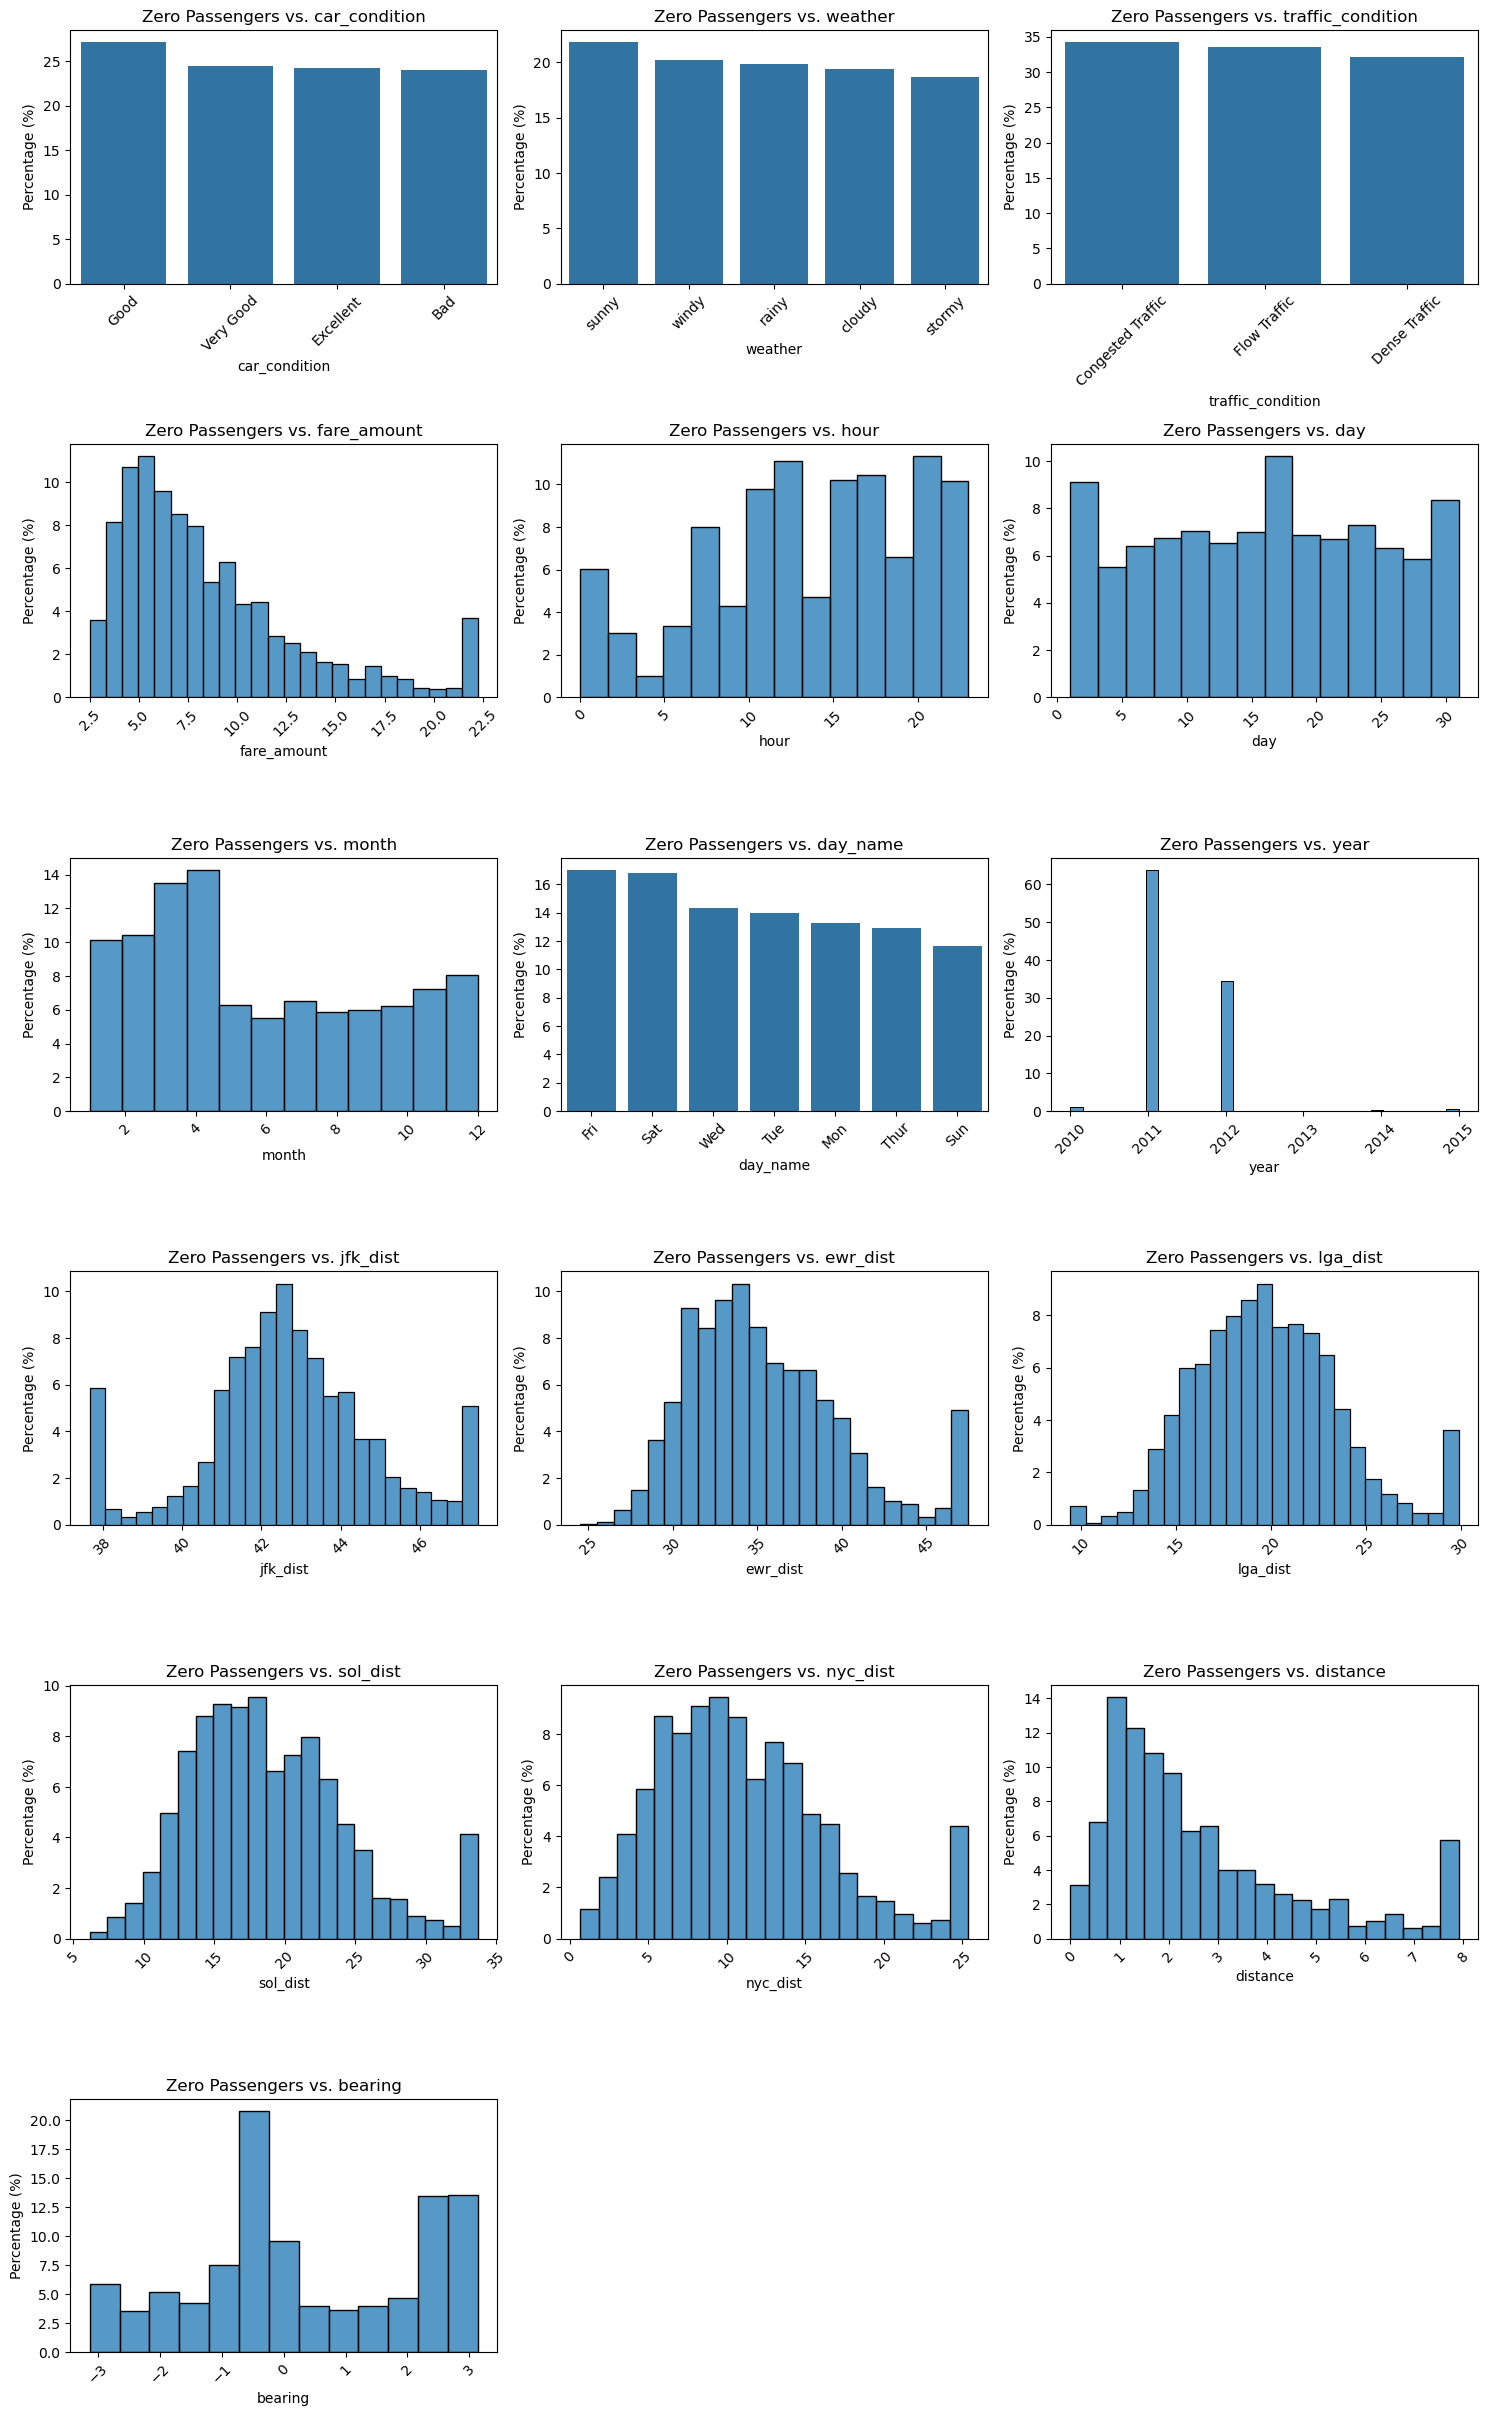

In [32]:
columns = [x for x in df.columns if 'passenger' not in x]
distribution_vis(df[df['passenger_count'] == 0][columns], "Zero Passengers vs. ")

**Summary of Zero Passengers vs. Features**:

- **Year**: Predominantly in 2011 and 2012.

**There’s no definitive explanation for the zero passenger count. It might indicate delivery trips, which were more common during 2011 and 2012 but are less frequent now.**

## Zero Distance

### Count

In [33]:
print("The count:", df[df['distance'] == 0].shape[0])
print("The Percentage:", format(df[df['distance'] == 0].shape[0] / df.shape[0] * 100, '0.5f') + '%')

The count: 14250
The Percentage: 2.85003%


### Zero Distance vs Features

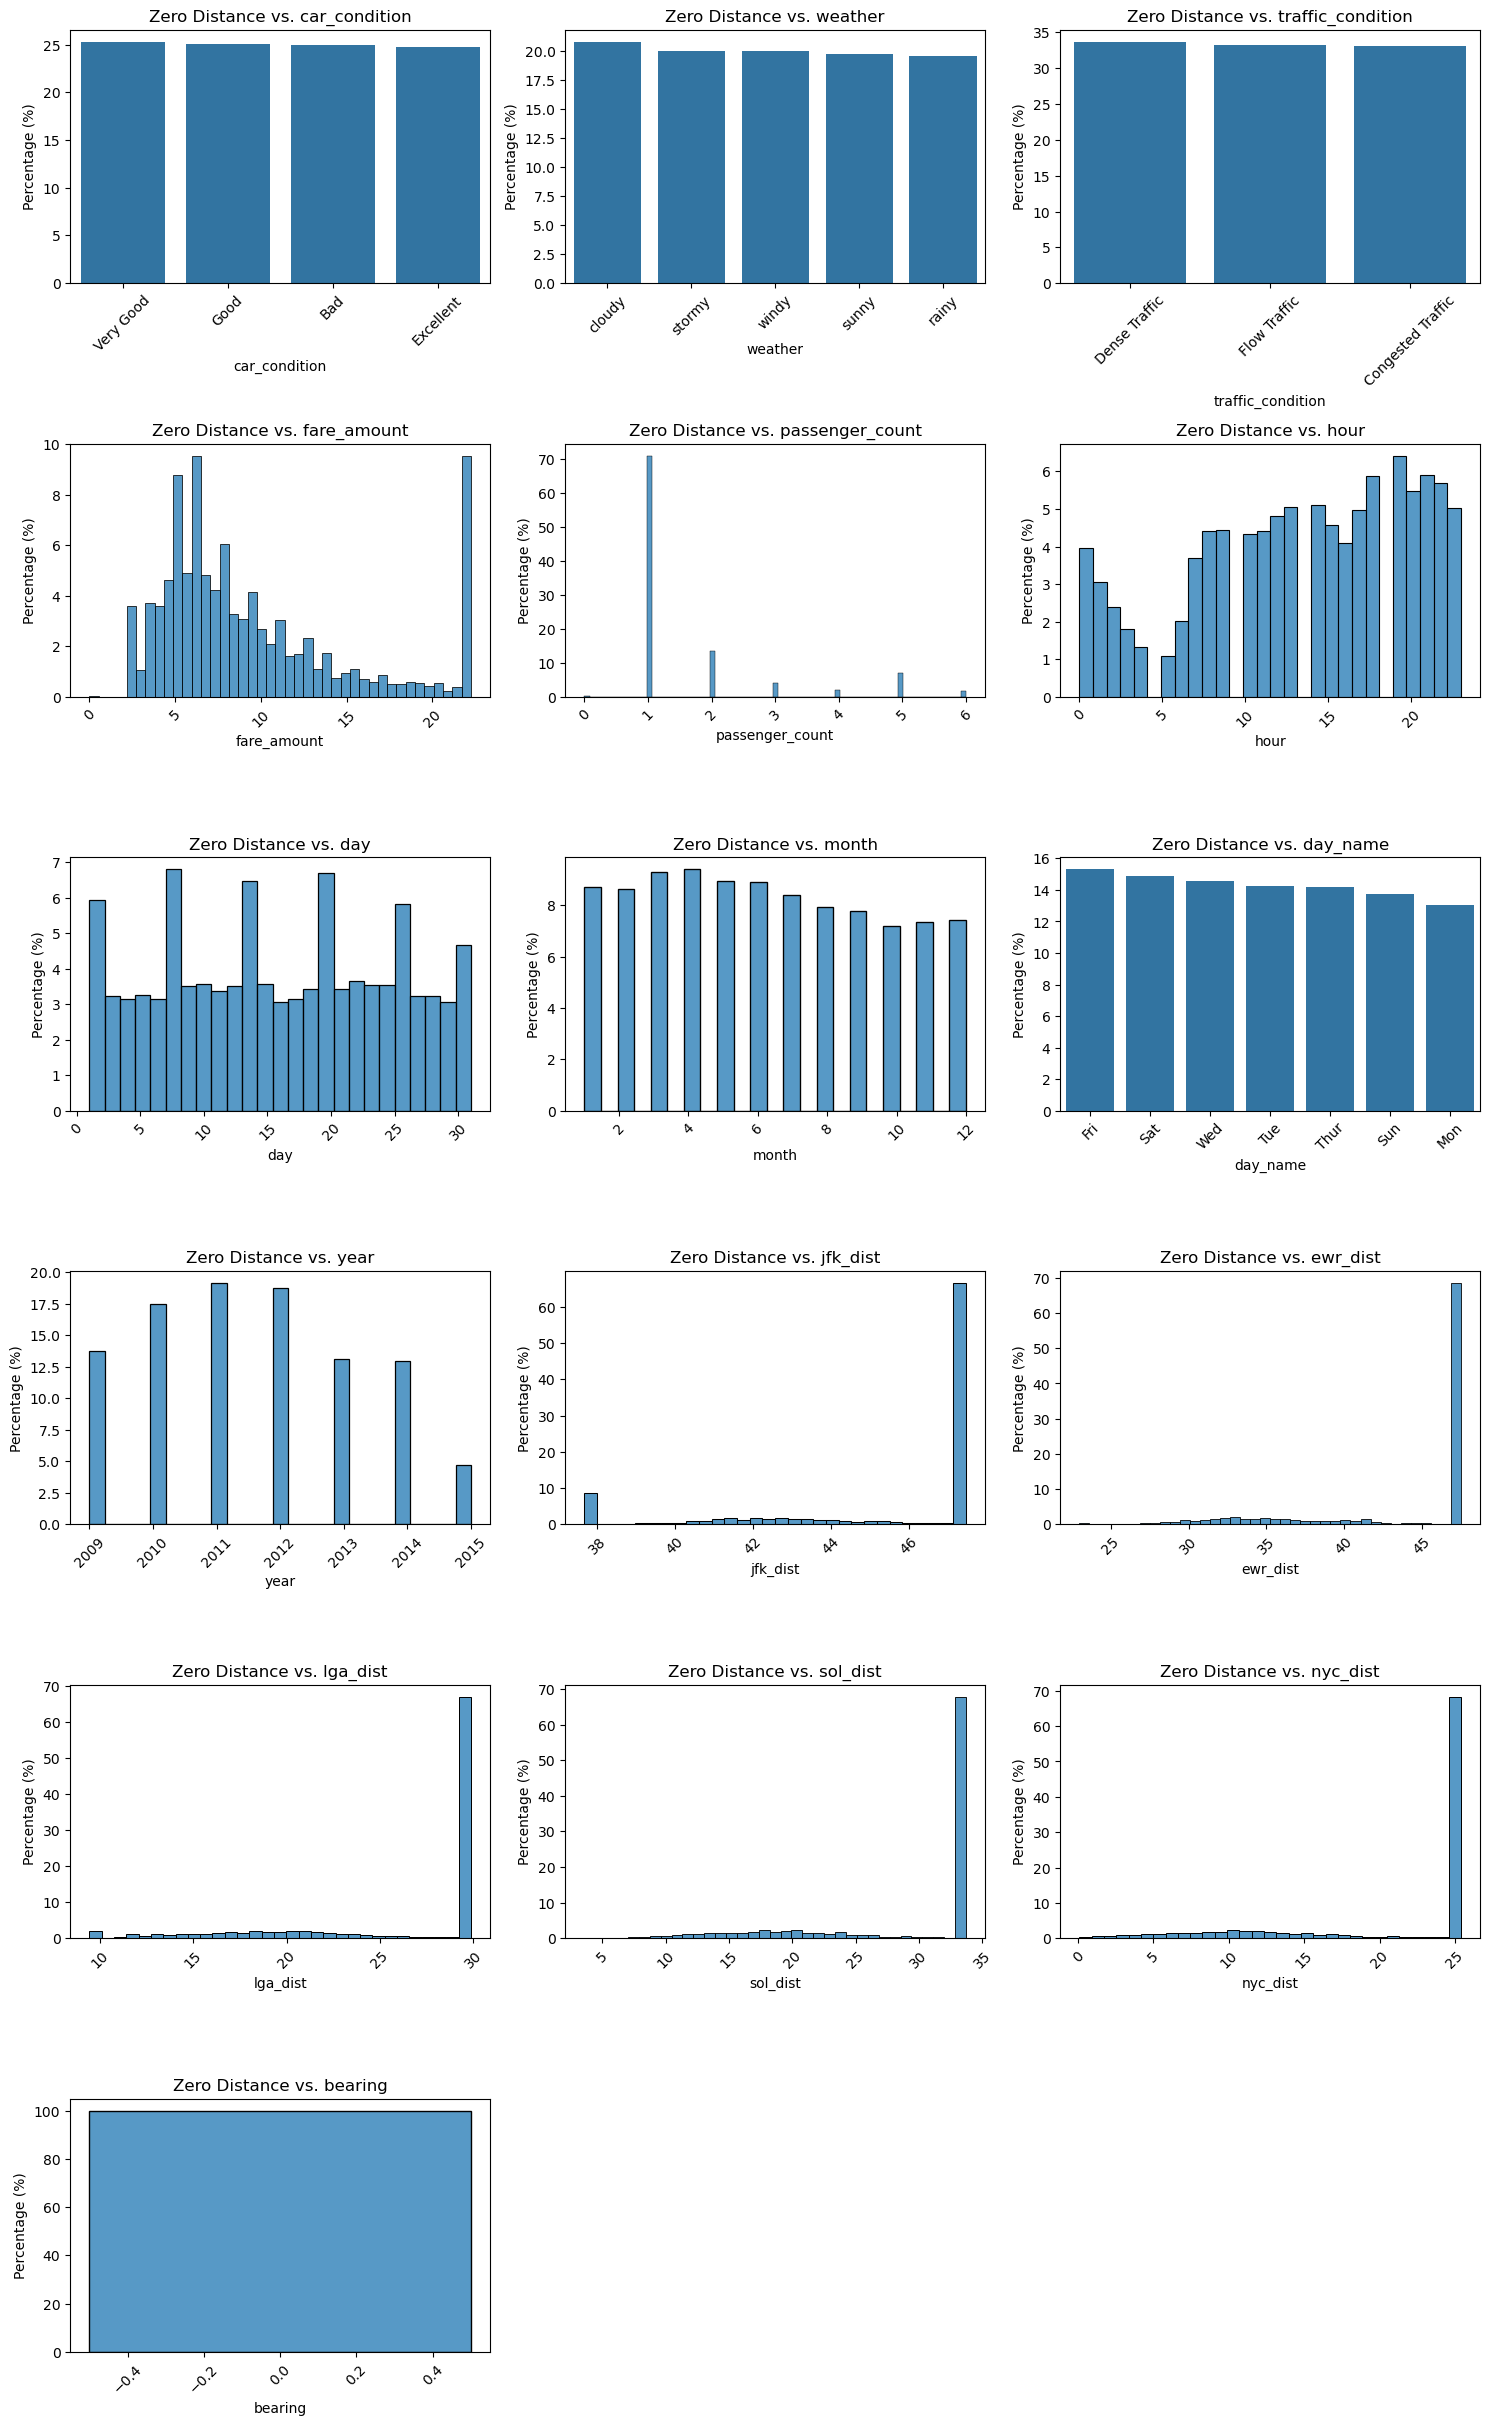

In [34]:
columns = [x for x in df.columns if x != 'distance']
distribution_vis(df[df['distance'] == 0][columns], "Zero Distance vs. ")

**Summary of Zero Distance vs. Features**:
- **Hour**: The majority of trips occur around 8 PM.
- **Distances**: Clustered around the maximum values.
- **Bearing**: Always zero.

**These might be canceled trips due to their very distant locations,they are big percent which can't be dropped it should be replaced by mean to not affect the fare prediction**

### Replacing by Mean

In [35]:
idx = df[df['distance'] == 0].index
df.loc[idx, 'distance'] = df['distance'].mean()

## Features Correlation Heatmap

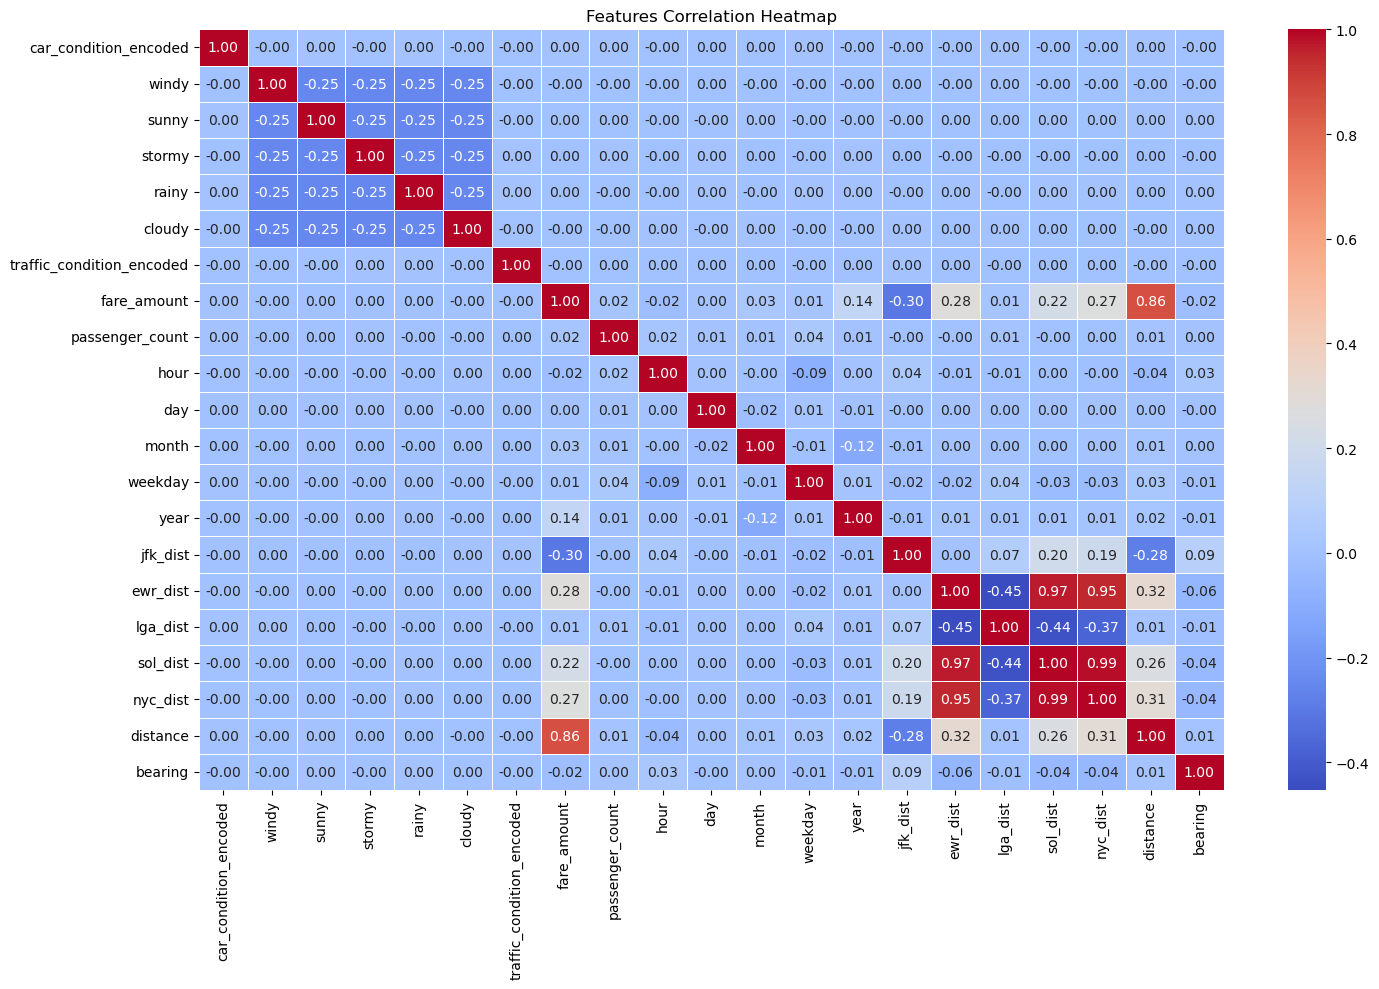

In [36]:
plt.figure(figsize=(15, 10))
sns.heatmap(df[numerical_columns].corr(), cmap='coolwarm', annot= True, fmt='.2f', linewidths=0.5)
plt.title("Features Correlation Heatmap")
plt.tight_layout()
plt.show()

**Features Correlation Summary**:
- **Fare and Distance**: There is a direct relationship between fare and distance.
- **Distances to Famous Locations**: These distances exhibit similar values, resulting in a high positive correlation.

**Note:** LaGuardia and John F. Kennedy Airports do not share similar values with other airports, indicating that they are farther away from them.

## Relation Visualization Function

In [37]:
def relation_vis(df, column2, title):
    rows = math.ceil(len(df.columns) / 3.0)
    fig, axes = plt.subplots(rows, 3, figsize = (15, 4 * rows))

    x = 0
    axes = axes.flatten()
    for column in df.columns:
        if column in ['weekday', 'sunny', 'windy', 'stormy', 'cloudy', 'rainy'] or 'encoded' in column or column == column2:
            continue

        df_grouped = df.groupby(column)[column2].mean().reset_index()            
        if column in categorical_columns:
            sns.barplot(ax=axes[x], x=df_grouped[column], y= df_grouped[column2])
        else:
            degree = 1
            if column == 'hour': degree=2 
            elif '_dist' in column: degree = 3
            sns.regplot(ax=axes[x], x=df_grouped[column], y= df_grouped[column2], scatter=False, order=degree)
            step = math.ceil(df_grouped[column].shape[0] / 50)
            axes[x].scatter(x=df_grouped[column][::step], y= df_grouped[column2][::step], color='red', s=10, label='Sampled Points') # Showing every 10th point
        axes[x].set_title(title + column)
        axes[x].set_xlabel(column)
        for label in axes[x].get_xticklabels():
            label.set_rotation(45)
        axes[x].set_ylabel(column2)
        x += 1

    for i in range(x, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

## Features Relation with Fare Amount

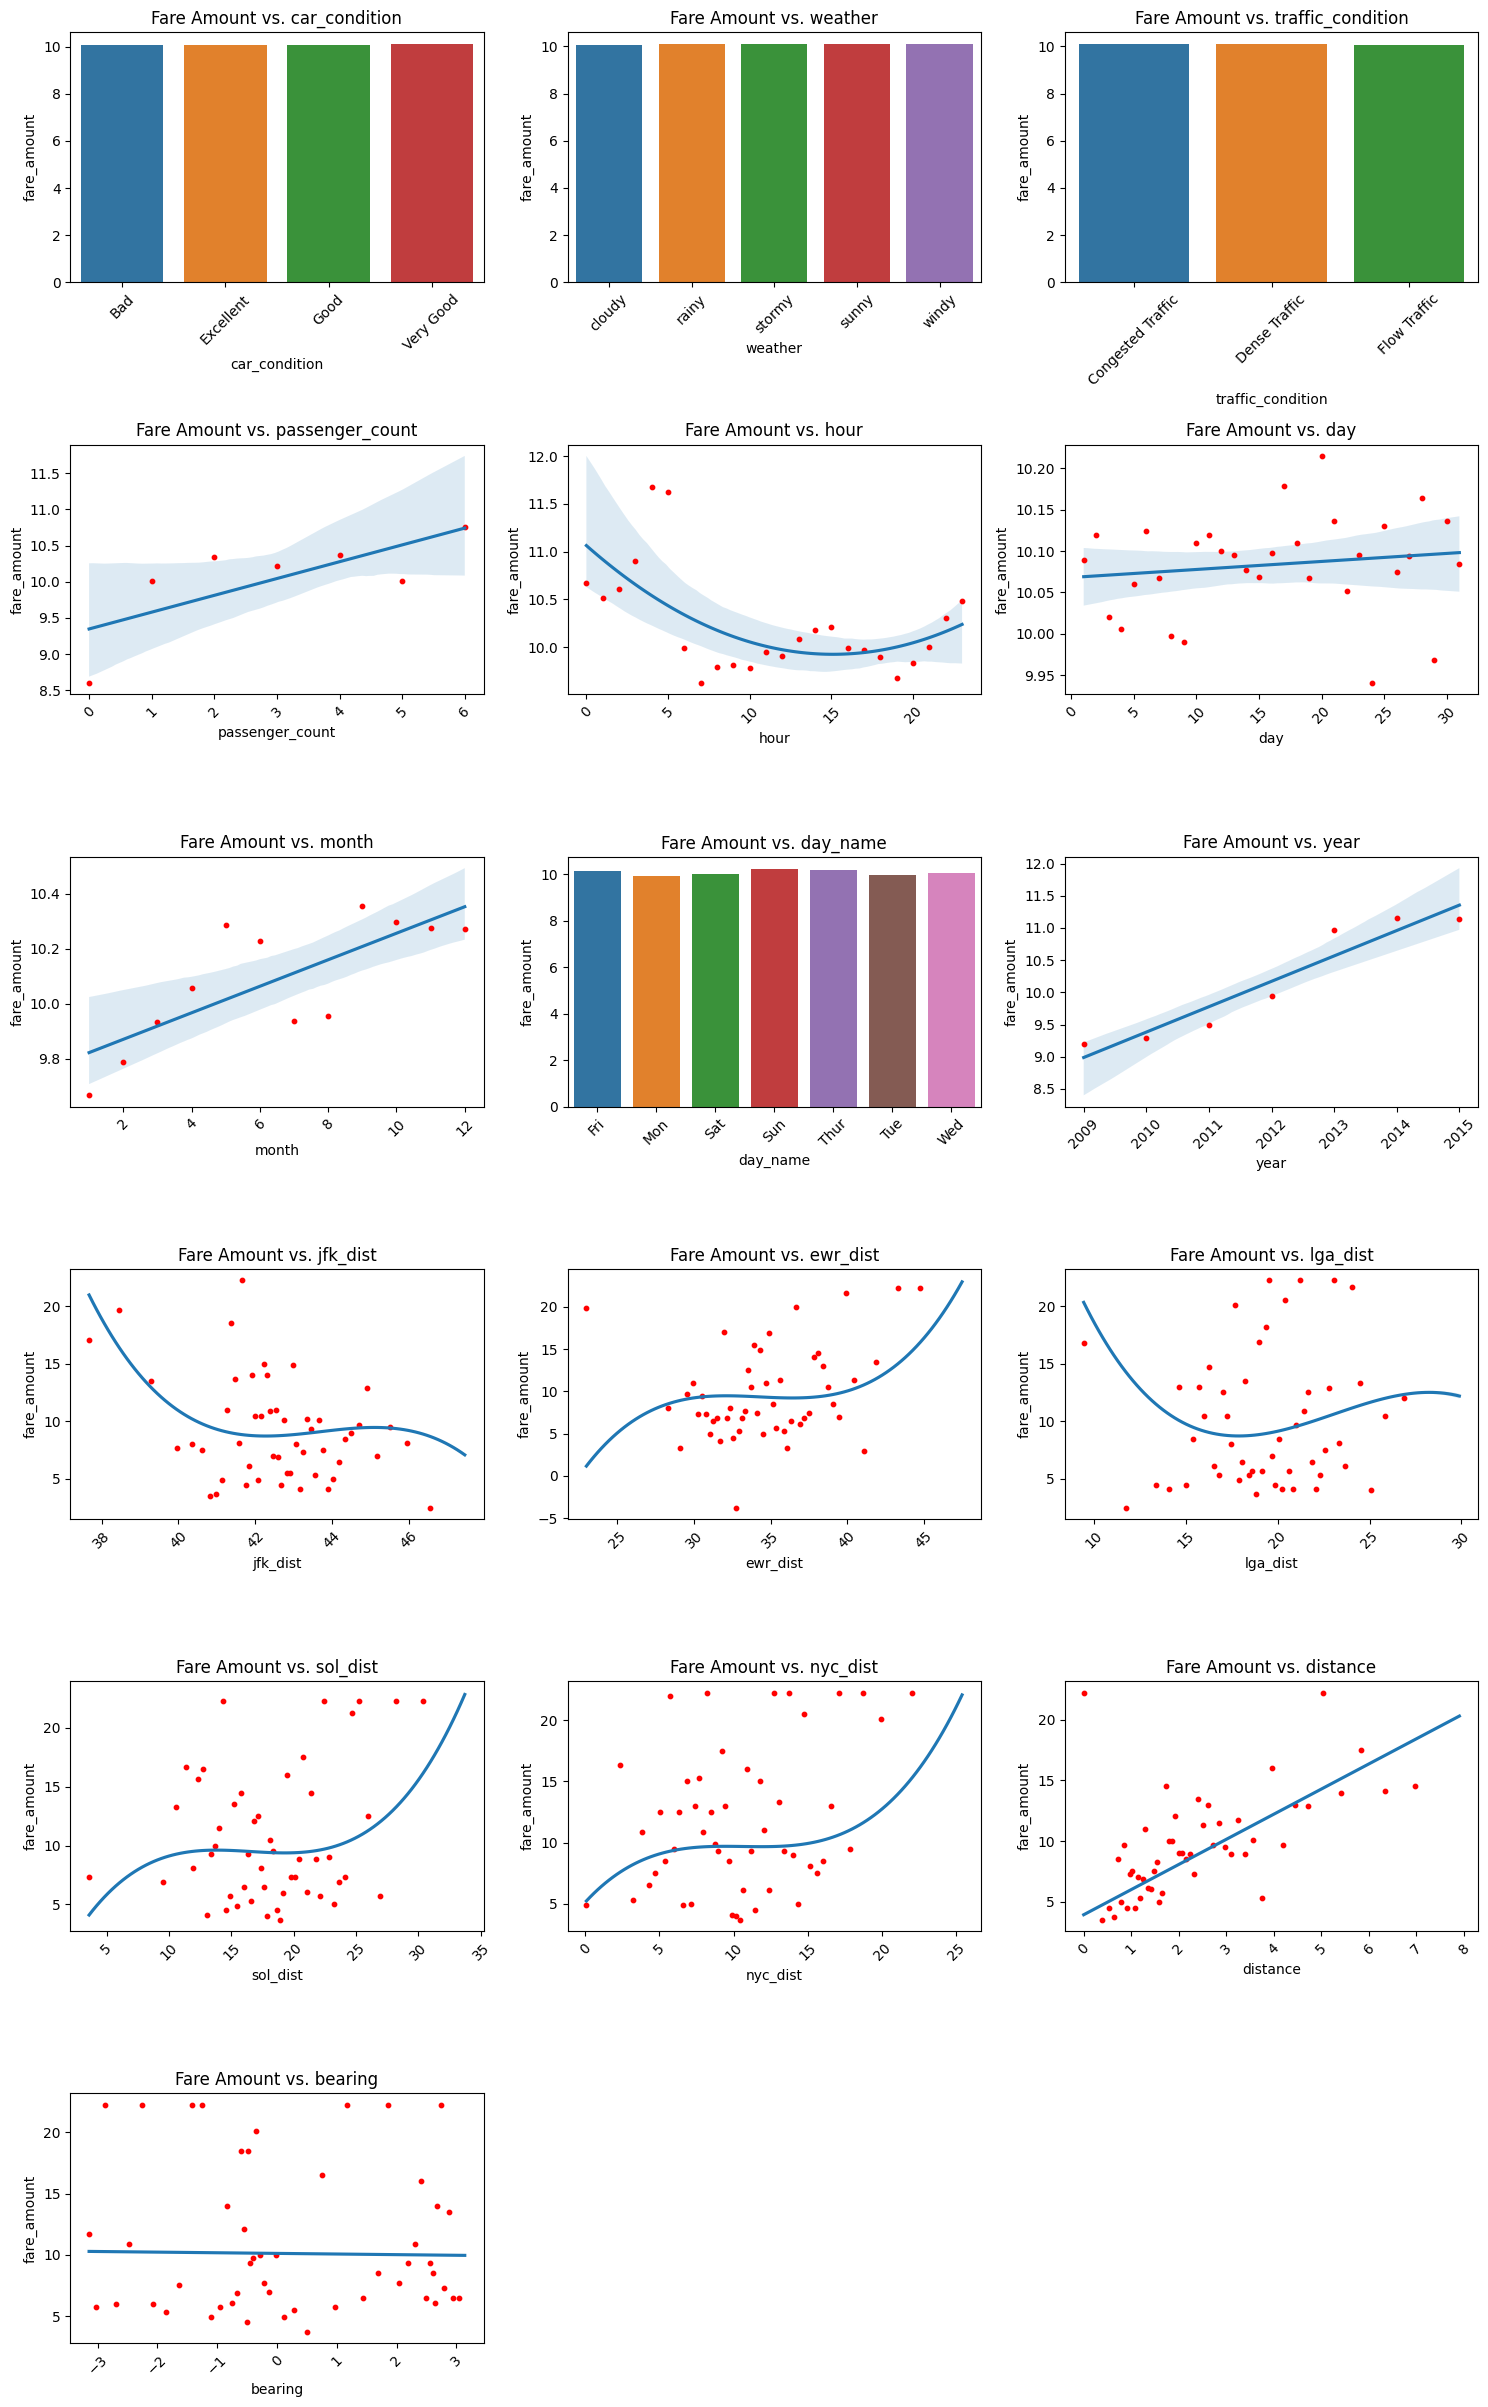

In [38]:
relation_vis(df, 'fare_amount', 'Fare Amount vs. ')

**Summary of Features vs. Fare Amount:**
- **Passenger Count**: Fares increase with the number of passengers.
- **Hour**: Higher fares are observed during late hours.
- **Month & Year**: Fares rise over time.
- **JFK Distance & LGA Distance**: Inversely related to fare.
- **EWR Distance, SOL Distance & NYC Distance**: Positively correlated with fare.
- **Trip Distance**: Longer trips result in higher fares.

# Data Preparation

## Drop Categorical Data

In [38]:
df = df.select_dtypes(['int64', 'float64'])
display(df.columns)

Index(['car_condition_encoded', 'windy', 'sunny', 'stormy', 'rainy', 'cloudy',
       'traffic_condition_encoded', 'fare_amount', 'passenger_count', 'hour',
       'day', 'month', 'weekday', 'year', 'jfk_dist', 'ewr_dist', 'lga_dist',
       'sol_dist', 'nyc_dist', 'distance', 'bearing'],
      dtype='object')

## MultiCollinearity

### VIF and Tolerance

In [39]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Add a constant to the dataframe for the intercept term
X = sm.add_constant(df)

# Calculate VIF and tolerance
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data["Tolerance"] = 1 / vif_data["VIF"]

print("VIF and Tolerance:")
print(vif_data)

e:\Programs\Anaconda\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
e:\Programs\Anaconda\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF and Tolerance:
                      feature         VIF  Tolerance
0                       const    0.000000        inf
1       car_condition_encoded    1.000044   0.999956
2                       windy         inf   0.000000
3                       sunny         inf   0.000000
4                      stormy         inf   0.000000
5                       rainy         inf   0.000000
6                      cloudy         inf   0.000000
7   traffic_condition_encoded    1.000047   0.999953
8                 fare_amount    4.266402   0.234390
9             passenger_count    1.002273   0.997732
10                       hour    1.012574   0.987582
11                        day    1.000552   0.999448
12                      month    1.019633   0.980745
13                    weekday    1.013184   0.986988
14                       year    1.082853   0.923486
15                   jfk_dist    2.959405   0.337906
16                   ewr_dist   41.189732   0.024278
17                   lga_di

**EWR Distance, SOL Distance & NYC Distance**: These features exhibit high multicollinearity and should be excluded from the analysis.

### High Multicollinearty Dropping

In [40]:
df.drop(columns=['ewr_dist', 'sol_dist', 'nyc_dist'], axis=1, inplace=True)

## Train - Test Split

In [41]:
X = df.drop('fare_amount', axis=1)
y = df['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
best_acc = {}

## Normalization

In [42]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
display(X_train)

array([[1.        , 0.        , 0.        , ..., 0.21619355, 0.41588107,
        0.43483622],
       [0.33333333, 0.        , 0.        , ..., 1.        , 0.14522036,
        0.95172976],
       [0.33333333, 0.        , 0.        , ..., 0.56615422, 0.07907901,
        0.95802426],
       ...,
       [0.33333333, 0.        , 0.        , ..., 0.84412203, 1.        ,
        0.93708376],
       [1.        , 0.        , 0.        , ..., 0.50735257, 0.16710962,
        0.78106525],
       [0.        , 0.        , 0.        , ..., 0.61561715, 0.60621246,
        0.43560233]])

# Model Training

## Linear Regression Model

### Model Training

Average MSE from Cross-Validation: 6.37
Train Mean Squared Error for Linear Regression: 6.31
Train R2 Score for Linear Regression: 0.79
Test Mean Squared Error for Linear Regression: 6.43
Test R2 Score for Linear Regression: 0.78


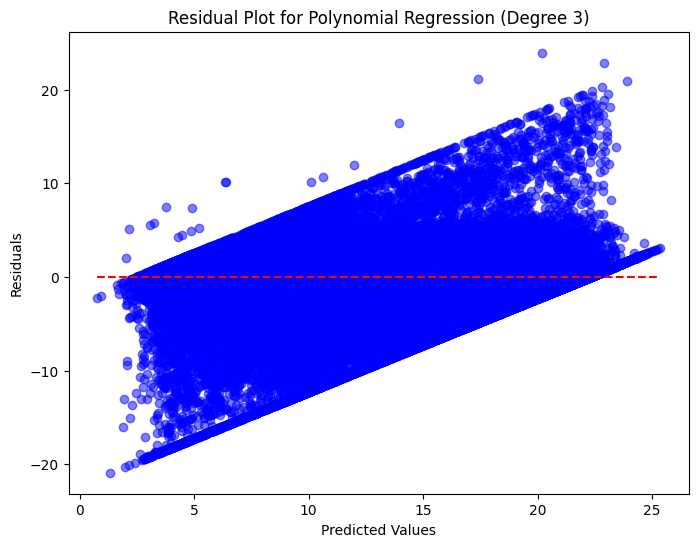

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Generate Polynomial Features (Degree = 3)
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train)  # Transform training data
X_test_poly = poly.transform(X_test)        # Transform testing data


# Define Linear Regression Model
lr_model = LinearRegression()

# Perform cross-validation
cv_scores = cross_val_score(lr_model, X_train_poly, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate the average MSE across the folds
avg_mse = -np.mean(cv_scores)
print(f"Average MSE from Cross-Validation: {avg_mse:.2f}")

# Train the model on the entire training data
lr_model.fit(X_train_poly, y_train)

# Train predictions and metrics
lr_y_pred_train = lr_model.predict(X_train_poly)
lr_mse_train = mean_squared_error(y_train, lr_y_pred_train)
lr_r2_train = r2_score(y_train, lr_y_pred_train)
print(f"Train Mean Squared Error for Linear Regression: {lr_mse_train:.2f}")
print(f"Train R2 Score for Linear Regression: {lr_r2_train:.2f}")

# Test predictions and metrics
lr_y_pred_test = lr_model.predict(X_test_poly)
lr_mse_test = mean_squared_error(y_test, lr_y_pred_test)
lr_r2_test = r2_score(y_test, lr_y_pred_test)
print(f"Test Mean Squared Error for Linear Regression: {lr_mse_test:.2f}")
print(f"Test R2 Score for Linear Regression: {lr_r2_test:.2f}")

# Residual plot
plt.figure(figsize=(8, 6))
plt.scatter(lr_y_pred_test, lr_y_pred_test - y_test, color='blue', alpha=0.5)
plt.hlines(y=0, xmin=lr_y_pred_test.min(), xmax=lr_y_pred_test.max(), colors='red', linestyles='dashed')
plt.title('Residual Plot for Polynomial Regression (Degree 3)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Update best accuracy
best_acc = {}  # Ensure this dictionary is defined
best_acc['Polynomial Regression (Degree 3)'] = lr_r2_test * 100

## Random Forest Model

### Model Training

Cross-Validation Mean Squared Error: 8.82 ± 0.14
Cross-Validation R2 Score: 0.70
Train Mean Squared Error for Random Forest: 1.64
Train R2 Score for Random Forest: 0.94
Test Mean Squared Error for Random Forest: 8.77
Test R2 Score for Random Forest: 0.71


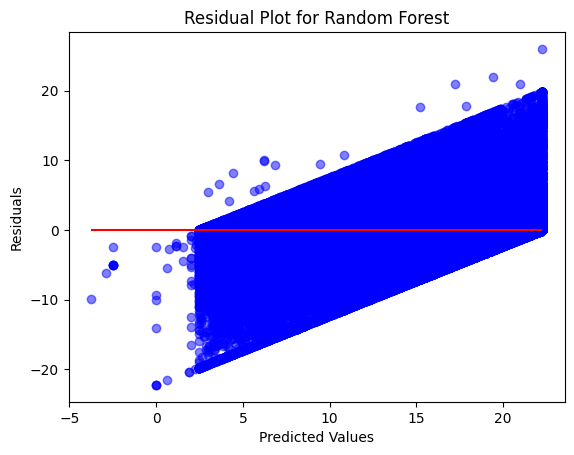

In [46]:
# Define Random Forest Regressor model with predefined parameters
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=30,
    min_samples_split=10,
    min_samples_leaf=1,
    bootstrap=False,
    random_state=42
)

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate cross-validation metrics
cv_mse_scores = -cv_scores
cv_mean_mse = np.mean(cv_mse_scores)
cv_std_mse = np.std(cv_mse_scores)
cv_mean_r2 = np.mean(cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2'))

print(f"Cross-Validation Mean Squared Error: {cv_mean_mse:.2f} ± {cv_std_mse:.2f}")
print(f"Cross-Validation R2 Score: {cv_mean_r2:.2f}")

# Train the model on the entire training set
rf_model.fit(X_train, y_train)

# Train predictions and metrics
rf_y_pred_train = rf_model.predict(X_train)
rf_mse_train = mean_squared_error(y_train, rf_y_pred_train)
rf_r2_train = r2_score(y_train, rf_y_pred_train)
print(f"Train Mean Squared Error for Random Forest: {rf_mse_train:.2f}")
print(f"Train R2 Score for Random Forest: {rf_r2_train:.2f}")

# Test predictions and metrics
rf_y_pred_test = rf_model.predict(X_test)
rf_mse_test = mean_squared_error(y_test, rf_y_pred_test)
rf_r2_test = r2_score(y_test, rf_y_pred_test)
print(f"Test Mean Squared Error for Random Forest: {rf_mse_test:.2f}")
print(f"Test R2 Score for Random Forest: {rf_r2_test:.2f}")

# Residual plot
plt.scatter(rf_y_pred_test, rf_y_pred_test - y_test, color='blue', alpha=0.5)
plt.hlines(y=0, xmin=rf_y_pred_test.min(), xmax=rf_y_pred_test.max(), colors='red')
plt.title('Residual Plot for Random Forest')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

best_acc['Random Forest'] = rf_r2_test * 100

### Feature Importance

Feature Importance for Random Forest:


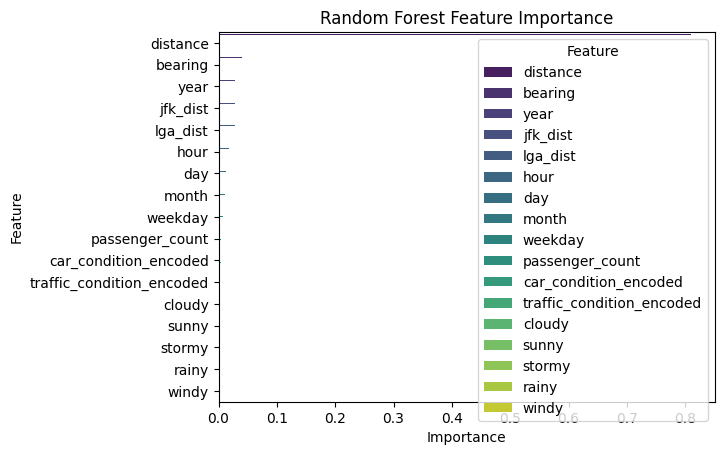

In [47]:
# Feature importances
rf_feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("Feature Importance for Random Forest:")
ax = sns.barplot(x='Importance', y='Feature', hue='Feature', data=rf_feature_importance_df, palette='viridis')
plt.title('Random Forest Feature Importance')
plt.show()

## Neural Network

### Model Training

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 13.1858 - val_loss: 6.5477
Epoch 2/100
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 6.6797 - val_loss: 6.4394
Epoch 3/100
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 6.6516 - val_loss: 6.4724
Epoch 4/100
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 6.4499 - val_loss: 6.1913
Epoch 5/100
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 6.2627 - val_loss: 6.2731
Epoch 6/100
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 6.2399 - val_loss: 6.0806
Epoch 7/100
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 6.1642 - val_loss: 6.0655
Epoch 8/100
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 5.9864 - val_loss: 5.8623
Epoch 9/100
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 5.9568 - val_loss: 6.0397
Epoch 10/100
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 5.8005 - val_loss: 5.8544
Epoch 11/100
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 5.8742 - val_loss: 5.7040
Epoch 12/100
6250

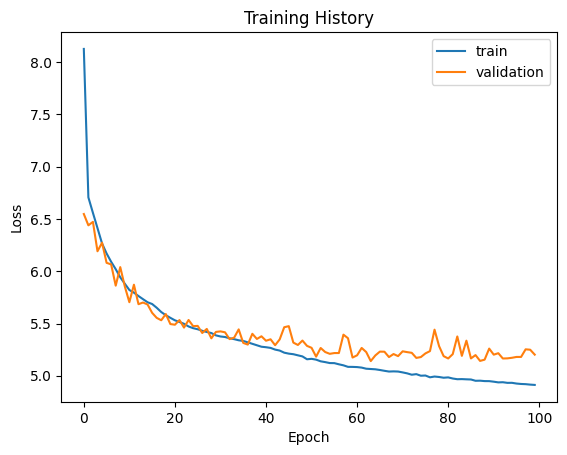

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define the neural network model
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=1)

# Evaluate the model
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate metrics
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train Mean Squared Error: {mse_train:.2f}")
print(f"Train R2 Score: {r2_train:.2f}")
print(f"Test Mean Squared Error: {mse_test:.2f}")
print(f"Test R2 Score: {r2_test:.2f}")

# Plot the training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Save the best accuracy for comparison
best_acc['Neural Network'] = r2_test * 100

### Permutation Importance

7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7813/7813 ━

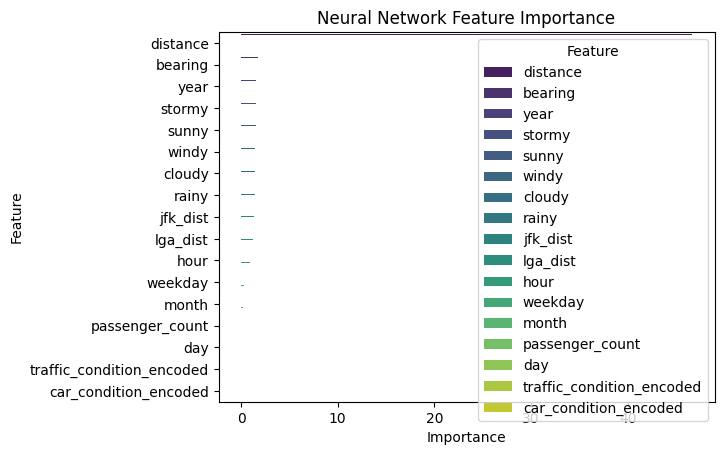

In [49]:
import eli5
from eli5.sklearn import PermutationImportance

# Permutation Importance
perm = PermutationImportance(model, scoring='neg_mean_squared_error', random_state=42)
perm.fit(X_test, y_test)

# Get feature importances and create a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importance for Neural Network:")
ax = sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_importance_df, palette='viridis')
plt.title('Neural Network Feature Importance')
plt.show()

## Accuracies Summary

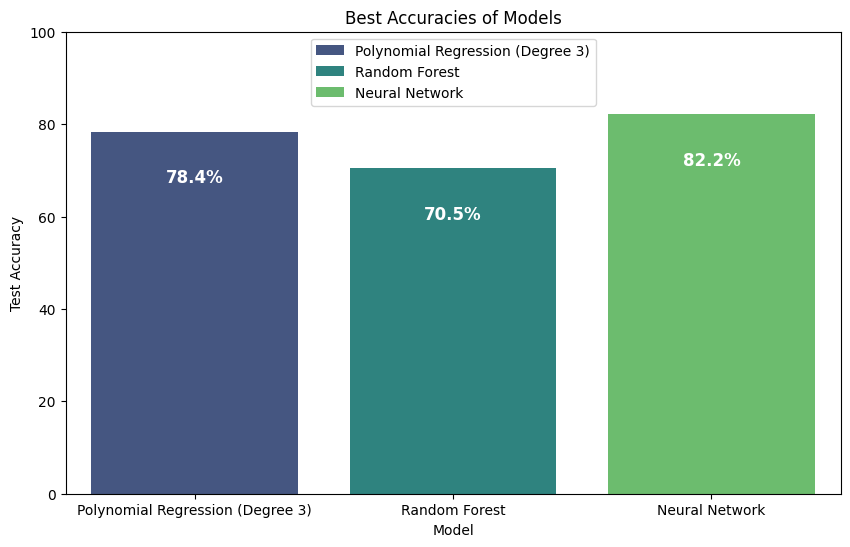

In [50]:
# Extract model names and accuracies
models = list(best_acc.keys())
accuracies = list(best_acc.values())

# Plot the accuracies
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=models, y=accuracies, hue=models, palette='viridis', dodge=False)
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Best Accuracies of Models')
plt.ylim(0, 100)

# Annotate each bar with its value, positioned closer to the bars
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy - 10, f'{accuracy:.1f}%', ha='center', va='center', color='white', fontsize=12, fontweight='bold')

plt.show()


# Model Deployment

In [ ]:
import pickle

# Save the encoder
with open('encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the model to a .pkl file
with open('NN_model.pkl', 'wb') as file:
    pickle.dump(model, file)